In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import rc_context
from scipy.stats import median_abs_deviation as mad
import os
import muon as mu
import decoupler as dc
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches


/opt/anaconda3/envs/survival/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=300,
    facecolor="white",
    frameon=False, fontsize = 8
)
sc.settings.figdir = '/Target_cohort/'
sns.set_theme(style="white")

In [3]:
manual_colors = {
    'cyto_group_new': {
        'others':     '#7f7f7f',  # gray
        'RUNX1r':     '#1f77b4',  # blue
        'CBFBr':      '#ff7f0e',  # orange
        'KMT2Ar':     '#2ca02c',  # green
        'PML-RARA':   '#d62728',  # red
        'NUP98r':     '#9467bd',  # purple
        'GLIS2r':     '#8c564b',  # brown
        'MNX1r':      '#e377c2',  # pink
        'DEK-NUP214': '#bcbd22',  # olive
    },
    'new_FAB': {
        'M3': '#e41a1c',  # red
        'M4': '#377eb8',  # blue
        'M5': '#4daf4a',  # green
        'M2': '#984ea3',  # purple
        'M1': '#ff7f00',  # orange
        'M7': '#ffff33',  # yellow
        'M6': '#a65628',  # brown
        'M0': '#f781bf',   # pink
        'unknown': "#7f7f7f"
    },
    'LSC_subtype': {
        'E-LSC enriched': 'purple',  # teal
        'M-LSC enriched': 'green',  # orange
        'P-LSC enriched': 'red',  # purple
        'Patient Specific': 'grey'   # pink
    }
}


In [4]:
colors_LSC =  {
        'E-LSC enriched': 'purple',  # teal
        'M-LSC enriched': 'green',  # orange
        'P-LSC enriched': 'red',  # purple
        'Patient Specific': 'grey'   # pink
    }

cyto_group_new =  {
        'others':     '#7f7f7f',  # gray
        'RUNX1r':     '#1f77b4',  # blue
        'CBFBr':      '#ff7f0e',  # orange
        'KMT2Ar':     '#2ca02c',  # green
        'PML-RARA':   '#d62728',  # red
        'NUP98r':     '#9467bd',  # purple
        'GLIS2r':     '#8c564b',  # brown
        'MNX1r':      '#e377c2',  # pink
        'DEK-NUP214': '#bcbd22',  # olive
    }   

ILIRAP_group =    {
    "IL1RAP_high" : "red",
    "IL1RAP_low" : "lightblue"
}  

new_FAB_col = {
        'M3': '#e41a1c',  # red
        'M4': '#377eb8',  # blue
        'M5': '#4daf4a',  # green
        'M2': '#984ea3',  # purple
        'M1': '#ff7f00',  # orange
        'M7': '#ffff33',  # yellow
        'M6': '#a65628',  # brown
        'M0': '#f781bf',   # pink
        'unknown': "#7f7f7f"
    }

In [5]:
def qc(adata):

    adata.obs_names_make_unique()
    adata.var_names_make_unique()
    
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
    adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True)
    
    return adata
def mad_outlier(adata, metric, nmads, upper_only = False):
    M = adata.obs[metric]
    
    if not upper_only:
        return (M < np.median(M) - nmads * mad(M)) | (M > np.median(M) + nmads * mad(M))
    
    return (M > np.median(M) + nmads * mad(M))    

def pp(adata):
    
    adata = adata[adata.obs.pct_counts_mt < 50] #you can lower this based on the overal distribution of your dataset
    
    bool_vector = mad_outlier(adata, 'log1p_total_counts', 8) +\
            mad_outlier(adata, 'log1p_n_genes_by_counts', 8) +\
            mad_outlier(adata, 'pct_counts_in_top_20_genes', 8)
    
    adata.obs["outlier"] = bool_vector
    
    return adata    

def normalize_expression(adata):
    """
    Basic normalization for gene expression data:
    1. Library size normalization
    2. Log transformation
    3. Scaling (z-score)
    """
    print("Normalizing expression data...")
    
    # Library size normalization
    sc.pp.normalize_total(adata, target_sum=1e4)
    
    # Log transform
    sc.pp.log1p(adata)
    
    # Scale each gene to zero mean and unit variance
    sc.pp.scale(adata)
    
    return adata    

def plot_boxplot_with_stats_gene(adata, categorical_col, gene_name, layer='X', figsize=(8, 6), 
                                palette=None, jitter=True, alpha=0.4, save_path=None, 
                                dpi=300, format='pdf', show_all_pairs=True, yline=None):
    from scipy import stats
    from scipy.stats import mannwhitneyu
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    from itertools import combinations
    import pandas as pd

    # Determine if gene_name is a gene or obs column
    is_gene = gene_name in adata.var_names
    is_obs_numerical = gene_name in adata.obs.columns and pd.api.types.is_numeric_dtype(adata.obs[gene_name])
    
    if not is_gene and not is_obs_numerical:
        raise ValueError(f"'{gene_name}' not found in adata.var_names or as numerical column in adata.obs")
    
    # Get data for plotting
    if is_gene:
        if layer == 'X':
            gene_expr = adata[:, gene_name].X.toarray().flatten() if hasattr(adata[:, gene_name].X, 'toarray') else adata[:, gene_name].X.flatten()
        else:
            if layer not in adata.layers:
                raise ValueError(f"Layer '{layer}' not found in adata.layers")
            gene_expr = adata[:, gene_name].layers[layer].toarray().flatten() if hasattr(adata[:, gene_name].layers[layer], 'toarray') else adata[:, gene_name].layers[layer].flatten()
        
        plot_data = adata.obs.copy()
        plot_data[gene_name] = gene_expr
        y_label = f'{gene_name} expression'
    else:
        plot_data = adata.obs.copy()
        gene_expr = adata.obs[gene_name].values
        plot_data[gene_name] = gene_expr
        y_label = gene_name

    plt.clf()
    plt.close('all')
    plt.figure(figsize=figsize)
    sns.set_style("whitegrid")

    if jitter:
        ax = sns.boxplot(data=plot_data, x=categorical_col, y=gene_name, palette=palette, showfliers=False)
        sns.stripplot(data=plot_data, x=categorical_col, y=gene_name, color='black', alpha=alpha, size=3)
    else:
        ax = sns.boxplot(data=plot_data, x=categorical_col, y=gene_name, palette=palette)

    ax.grid(False)
    ax.set_axisbelow(False)

    categories = sorted(plot_data[categorical_col].unique())
    test_results = {}

    if len(categories) >= 2:
        if len(categories) == 2:
            cat1_data = plot_data[plot_data[categorical_col] == categories[0]][gene_name]
            cat2_data = plot_data[plot_data[categorical_col] == categories[1]][gene_name]
            stat, pval = mannwhitneyu(cat1_data, cat2_data, alternative='two-sided')
            test_results[f"{categories[0]}_vs_{categories[1]}"] = {'statistic': stat, 'pvalue': pval}
            test_name = "Mann-Whitney U test"
        else:
            groups = [group for name, group in plot_data.groupby(categorical_col)[gene_name]]
            stat, pval = stats.kruskal(*groups)
            test_results['kruskal_wallis'] = {'statistic': stat, 'pvalue': pval}
            test_name = "Kruskal-Wallis H-test"

            if show_all_pairs:
                for i, j in combinations(range(len(categories)), 2):
                    cat1_data = plot_data[plot_data[categorical_col] == categories[i]][gene_name]
                    cat2_data = plot_data[plot_data[categorical_col] == categories[j]][gene_name]
                    pair_stat, pair_pval = mannwhitneyu(cat1_data, cat2_data, alternative='two-sided')
                    test_results[f"{categories[i]}_vs_{categories[j]}"] = {'statistic': pair_stat, 'pvalue': pair_pval}

        if show_all_pairs and len(categories) > 1:
            y_max = plot_data[gene_name].max()
            y_min = plot_data[gene_name].min()
            y_range = y_max - y_min
            bar_spacing = y_range * 0.05
            current_bar_height = y_max + y_range * 0.1

            significant_pairs = []
            for pair_name, result in test_results.items():
                if pair_name != 'kruskal_wallis':
                    significant_pairs.append((pair_name, result['pvalue']))
            significant_pairs.sort(key=lambda x: x[1])

            for pair_name, p_val in significant_pairs:
                cat1, cat2 = pair_name.split('_vs_')
                idx1 = categories.index(cat1)
                idx2 = categories.index(cat2)
                bar_tips = current_bar_height - bar_spacing
                plt.plot([idx1, idx1, idx2, idx2],
                         [bar_tips, current_bar_height, current_bar_height, bar_tips],
                         'k-', linewidth=1)

                p_text = f"p={p_val:.1e}"
                plt.text((idx1 + idx2) / 2, current_bar_height + bar_spacing/2,
                         p_text,
                         ha='center', va='bottom', fontsize=9)

                current_bar_height += bar_spacing * 2

            plt.ylim(y_min - y_range * 0.1, current_bar_height + bar_spacing)

        print(f"\n{test_name} results:")
        print(f"p-value: {pval:.2e}")
        if len(categories) > 2 and show_all_pairs:
            print("\nPairwise comparisons (Mann-Whitney U test):")
            for pair_name, result in test_results.items():
                if pair_name != 'kruskal_wallis':
                    print(f"{pair_name}: p={result['pvalue']:.2e}")

    # Add optional horizontal line
    if yline is not None:
        plt.axhline(y=yline, color='red', linestyle='--', linewidth=1)
    
    data_type = "expression" if is_gene else "values"
    plt.title(f'{gene_name} {data_type} by {categorical_col}')
    plt.ylabel(y_label)
    plt.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, format=format, dpi=dpi, bbox_inches='tight')
        print(f"Figure saved to: {save_path}")
    
    plt.show()
    return test_results

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

def plot_gene_scatter_with_lines(
    adata,
    gene_x,
    gene_y,
    group_col,
    s,
    x_line=None,
    y_line=None,
    figsize=(8, 6),
    palette='tab10',
    save_path=None,
    dpi=300,
    format='pdf',
    layer='X'
):
    """
    Plots a scatter plot of two gene expressions from an AnnData object.
    """
    # Sanity check for gene presence
    if gene_x not in adata.var_names or gene_y not in adata.var_names:
        raise ValueError(f"One or both genes '{gene_x}' or '{gene_y}' not found in adata.var_names.")

    # Extract gene expression
    def get_gene_values(gene):
        if layer == 'X':
            data = adata[:, gene].X
        else:
            if layer not in adata.layers:
                raise ValueError(f"Layer '{layer}' not found in adata.layers")
            data = adata[:, gene].layers[layer]

        # Convert to 1D numpy array
        if hasattr(data, 'toarray'):
            data = data.toarray()
        return data.flatten()

    x_vals = get_gene_values(gene_x)
    y_vals = get_gene_values(gene_y)

    # Build dataframe for plotting
    df = adata.obs.copy()
    df[gene_x] = x_vals
    df[gene_y] = y_vals

    # Drop rows with missing values
    df = df.dropna(subset=[gene_x, gene_y, group_col])

    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)
    sns.scatterplot(data=df, x=gene_x, y=gene_y, hue=group_col, palette=palette, s=s, alpha=0.7, ax=ax, edgecolor='none')

    # Add threshold lines if given
    if x_line is not None:
        ax.axvline(x=x_line, linestyle='--', color='black', linewidth=1)

    if y_line is not None:
        ax.axhline(y=y_line, linestyle='--', color='black', linewidth=1)

    ax.set_title(f'{gene_y} vs {gene_x} by {group_col}')
    ax.set_xlabel(gene_x)
    ax.set_ylabel(gene_y)

    # Fix legend
    handles, labels = ax.get_legend_handles_labels()
    if len(labels) > 0:
        ax.legend(title=group_col, bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        ax.legend_.remove()

    plt.tight_layout()

    # Save if requested
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        fig.savefig(save_path, dpi=dpi, format=format, bbox_inches='tight')
        print(f"Figure saved to: {save_path}")


def label_high_low_gene_expression(adata, gene_name, layer='X', obs_column_name=None):
    """
    Labels cells as 'high' or 'low' based on mean expression of a given gene.

    Parameters
    ----------
    adata : AnnData
        The AnnData object.
    gene_name : str
        Gene to evaluate.
    layer : str
        Layer from which to pull expression values (default is 'X').
    obs_column_name : str or None
        Name of new column in `adata.obs`. If None, defaults to '{gene_name}_high_low'.

    Returns
    -------
    None
        Adds a column to `adata.obs` with 'high' or 'low' labels.
    """
    import numpy as np

    # Check that gene exists
    if gene_name not in adata.var_names:
        raise ValueError(f"Gene '{gene_name}' not found in adata.var_names")

    # Get expression
    if layer == 'X':
        expr = adata[:, gene_name].X
    else:
        if layer not in adata.layers:
            raise ValueError(f"Layer '{layer}' not found in adata.layers")
        expr = adata[:, gene_name].layers[layer]

    # Convert to array if needed
    expr = expr.toarray().flatten() if hasattr(expr, 'toarray') else np.array(expr).flatten()

    # Determine threshold
    mean_expr = np.mean(expr)

    # Label cells
    labels = np.where(expr >= mean_expr, gene_name + '_high',gene_name + '_low')

    # Create column name if not provided
    if obs_column_name is None:
        obs_column_name = f"{gene_name}_high_low"

    # Add to adata.obs
    adata.obs[obs_column_name] = labels


In [6]:
#Loading and cleaning TARGET data
target_new = sc.read_csv("/GDCdata/matrix_raw.csv").T

#target_new.raw = target_new
target_new.layers["raw_counts"] = target_new.X.copy()
meta = pd.read_csv("/Users/sina.kanannejad/GDCdata/GDCdata/meta_new.csv", index_col= 0)
target_new.obs = meta
target_new = target_new[~target_new.obs["definition"].isin(["Bone Marrow Normal","Next Generation Cancer Model","Blood Derived Normal","Blood Derived Cancer- Bone Marrow",
                                                             "Post-treatment","Cell line from patient tumor","Blood Derived Cancer- Peripheral Blood, Post-treatment"])]
unique_mask = ~target_new.obs.duplicated(subset="case.unique.id", keep="first")
target_new_WD = target_new[unique_mask].copy()
target_new_WD

/opt/anaconda3/envs/survival/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/opt/anaconda3/envs/survival/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/envs/survival/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 2121 × 60660
    obs: 'barcode', 'tumor.code', 'sample', 'patient', 'case.unique.id', 'tissue.code', 'nucleic.acid.code', 'definition', 'tumor.definition', 'nucleic.acid.description', 'sample_submitter_id', 'sample_type_id', 'tumor_descriptor', 'sample_id', 'sample_type', 'tumor_code', 'state', 'preservation_method', 'submitter_id', 'tumor_code_id', 'specimen_type', 'tissue_type', 'tissue_or_organ_of_origin', 'age_at_diagnosis', 'morphology', 'classification_of_tumor', 'icd_10_code', 'days_to_diagnosis', 'primary_diagnosis', 'year_of_diagnosis', 'diagnosis_is_primary_disease', 'diagnosis_id', 'site_of_resection_or_biopsy', 'race', 'gender', 'ethnicity', 'vital_status', 'age_at_index', 'days_to_birth', 'demographic_id', 'age_is_obfuscated', 'bcr_patient_barcode', 'dbgap_accession_number', 'project_id', 'name', 'releasable', 'released', 'days_to_death', 'freezing_method', 'oct_embedded'
    layers: 'raw_counts'

In [9]:
dfs = []

base_dir = "/Bulk_Target_data/Clinical/Clinical_Supplement/"
for file in os.listdir(base_dir):
    dir_path = os.path.join(base_dir, file)  # Correct method to join paths
    
    # Check if the file is an Excel file (optional)
    if file.endswith(".xlsx") or file.endswith(".xls"):
        excel_file = pd.read_excel(dir_path, index_col=0)
        
        # Append the DataFrame to the list
        dfs.append(excel_file)

# Combine all DataFrames into one (if needed)
combined_df = pd.concat(dfs)


target_new_clean = target_new_WD.copy()
target_new_clean.var_names_make_unique()

map_prim_cyto_target_id = dict(zip(combined_df.index, combined_df["Primary Cytogenetic Code"]))
map_Cyto_target_id = dict(zip(combined_df.index, combined_df["Gene Fusion"]))
map_os_target_id = dict(zip(combined_df.index, combined_df["Overall Survival Time in Days"]))
map_efs_target_id = dict(zip(combined_df.index, combined_df["Event Free Survival Time in Days"]))
map_first_event_target_id = dict(zip(combined_df.index, combined_df["First Event"]))
fab_cat = dict(zip(combined_df.index, combined_df["FAB Category"]))
flt_itd_pos = dict(zip(combined_df.index, combined_df["FLT3/ITD positive?"]))
npm_mu =  dict(zip(combined_df.index, combined_df["NPM mutation"]))
cebp_mu =  dict(zip(combined_df.index, combined_df["CEBPA mutation"]))
wt1_mu =  dict(zip(combined_df.index, combined_df["WT1 mutation"]))
WBC =  dict(zip(combined_df.index, combined_df["WBC at Diagnosis"]))
gender =  dict(zip(combined_df.index, combined_df["Gender"]))
riskg =  dict(zip(combined_df.index, combined_df["Risk group"]))





target_new_clean.obs["EFS_days"] = target_new_clean.obs["patient"].map(map_efs_target_id)
target_new_clean.obs["OS_days"] = target_new_clean.obs["patient"].map(map_os_target_id)
target_new_clean.obs["cyto"] = target_new_clean.obs["patient"].map(map_Cyto_target_id)
target_new_clean.obs["cyto_prim"] = target_new_clean.obs["patient"].map(map_prim_cyto_target_id)
target_new_clean.obs["event"] = target_new_clean.obs["patient"].map(map_first_event_target_id)
target_new_clean.obs["FAB_cat"] = target_new_clean.obs["patient"].map(fab_cat)
target_new_clean.obs["FLT-ITD"] = target_new_clean.obs["patient"].map(flt_itd_pos)
target_new_clean.obs["NPM1_mut"] = target_new_clean.obs["patient"].map(npm_mu)
target_new_clean.obs["CEBP_mut"] = target_new_clean.obs["patient"].map(cebp_mu)
target_new_clean.obs["WT1_mut"] = target_new_clean.obs["patient"].map(wt1_mu)
target_new_clean.obs["WBC"] = target_new_clean.obs["patient"].map(WBC)
target_new_clean.obs["gender"] = target_new_clean.obs["patient"].map(gender)
target_new_clean.obs["risk_group"] = target_new_clean.obs["patient"].map(riskg)



#mask_nan_status = ~target_new_clean.obs["event"].isna()
#adata_target_AML = target_new_clean[mask_nan_status].copy()
#print(f"Removed {sum(~mask_nan_status)} samples with NaN vital status")

target_new_clean.X = target_new_clean.layers["raw_counts"].copy()
sc.pp.normalize_total(target_new_clean, target_sum=1e6)
sc.pp.log1p(target_new_clean)
target_new_clean.layers["log_norm"] = target_new_clean.X.copy()
#sc.pp.scale(target_new_clean)
target_new_clean.X.max()

#cleaning meta
target_new_clean.obs["event"] = target_new_clean.obs["event"].replace("Induction Failure", "Induction failure")
target_new_clean.obs["event"] = target_new_clean.obs["event"].replace("Death without Remission", "Death without remission")

target_new_clean.obs["cyto_new"] = target_new_clean.obs["cyto_prim"].astype("str") + target_new_clean.obs["cyto"].astype("str")

def annotate_cytogenetics(names):
    result = []
    for name in names:
        if "KMT2A" in name or "MLL" in name:
            result.append("KMT2Ar")
        elif "t(8;21)" in name or "RUNX1-RUNX1T1" in name:
            result.append("RUNX1r")
        elif "inv(16)" in name or "CBFB-MYH11" in name:
            result.append("CBFBr")
        elif "CBFA2T3-GLIS2" in name:
            result.append("GLIS2r")
        elif "DEK-NUP214" in name:
            result.append("DEK-NUP214")
        elif "NUP98" in name:
            result.append("NUP98r")
        elif "MNX1-ETV6" in name:
            result.append("MNX1r")
        elif "PML-RARA" in name:
            result.append("PML-RARA")    
        else:
            result.append("others")
    return result

# Apply to obs column
target_new_clean.obs["cyto_group_new"] = annotate_cytogenetics(target_new_clean.obs["cyto_new"])


def clean_annot_fab (FAB_cat):
    if FAB_cat in ["M0 Undifferentiated"]:
        return "M0"
    elif FAB_cat in ["M1"]:
        return "M1"    
    elif FAB_cat in ["M2"]:
        return "M2"
    elif FAB_cat in ["M3"]:
        return "M3"   
    elif FAB_cat in ["M4"]:
        return "M4"      
    elif FAB_cat in ["M5"]:
        return "M5"   
    elif FAB_cat in ["M6"]:
        return "M6"    
    elif FAB_cat in ["M7"]:
        return "M7"                 
    else:
        return "unknown"

target_new_clean.obs["new_FAB"] =   target_new_clean.obs["FAB_cat"].map(clean_annot_fab)     


/opt/anaconda3/envs/survival/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/envs/survival/lib/python3.10/site-packages/anndata/utils.py:268: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD115-1', 'SNORD115-2', 'SNORD115-3', 'SNORD115-4', 'SNORD115-5']
  warnings.warn(


In [52]:
mdata = mu.read("/LSC_like_all.h5mu")
sc.tl.rank_genes_groups(mdata["rna"], groupby="ADT_group", method="wilcoxon", pts = True, layer = "lognorm_counts")
results = []
n_top =50
for lsc in ["E-LSC", "P-LSC", "M-LSC"]:
    markers_df = sc.get.rank_genes_groups_df(mdata["rna"], group=lsc)
    top_markers = list(markers_df["names"][0:n_top])
    results.extend(top_markers)  # Use extend to flatten the list

# Remove duplicates while preserving order
merged_markers = list(dict.fromkeys(results))

print(f"Total unique markers: {len(merged_markers)}")


Total unique markers: 148


In [53]:
#Deconvolution 

expr_sc = mdata["rna"][:, merged_markers].copy()
sc.pp.normalize_total(expr_sc, target_sum=1e6)
sc.pp.log1p(expr_sc)
expr_sc.layers["log_norm"] = expr_sc.X.copy()
expr_sc_df = pd.DataFrame(expr_sc.X.toarray(), index = expr_sc.obs_names, columns = expr_sc.var_names)
expr_sc_df["ADT_group"] = expr_sc.obs["ADT_group"]
signature_matrix = expr_sc_df.groupby("ADT_group").mean().T
common_genes = signature_matrix.index.intersection(target_new_clean.var_names)
signature_matrix = signature_matrix.loc[common_genes]


bulk_expr = target_new_clean[:,common_genes].copy()
bulk_expr_df = pd.DataFrame(bulk_expr.X.T, index = bulk_expr.var_names, columns = bulk_expr.obs_names)

proportions = {}
for sample in bulk_expr_df.columns:
    y = bulk_expr_df[sample].values
    model = Lasso(alpha=1.0, positive=True)
    model.fit(signature_matrix.values, y)
    w = model.coef_
    w = w / w.sum()  # Normalize to sum to 1
    proportions[sample] = w

# Make proportions dataframe
df_props = pd.DataFrame(proportions, index=signature_matrix.columns).T
df_props


ADT_group                    E-LSC     M-LSC     P-LSC  Patient Specific
TARGET-20-PAVDAJ-09A-01R  0.000000  0.138969  0.861031               0.0
TARGET-20-PAXBXU-09A-01R  0.000000  0.091741  0.908259               0.0
TARGET-20-PAWDKU-09A-01R  0.000000  0.115072  0.884928               0.0
TARGET-20-PAUVMN-09A-01R  0.000000  0.000000  1.000000               0.0
TARGET-20-PAXEWS-09A-01R  0.257034  0.000000  0.742966               0.0
...                            ...       ...       ...               ...
TARGET-20-PASLMR-09A-01R  0.000000  0.847986  0.152014               0.0
TARGET-20-PANZXI-09A-01R  0.000000  0.000000  1.000000               0.0
TARGET-20-PANXWX-09A-01R  0.000000  1.000000  0.000000               0.0
TARGET-20-PARXNG-09A-01R  0.000000  0.358172  0.641828               0.0
TARGET-20-PARIZR-03A-02R  0.000000  0.330604  0.669396               0.0

[2121 rows x 4 columns]

In [54]:
target_new_clean.obs["P-LSC"] = df_props["P-LSC"]
target_new_clean.obs["M-LSC"] = df_props["M-LSC"]
target_new_clean.obs["E-LSC"] = df_props["E-LSC"]
target_new_clean.obs["Patient Specific"] = df_props["Patient Specific"]

cols = ["P-LSC", "M-LSC", "E-LSC","Patient Specific"]

# Get the argmax index per row
max_idx = target_new_clean.obs[cols].to_numpy().argmax(axis=1)
max_idx

mapping = {0: "P-LSC enriched", 1: "M-LSC enriched", 2: "E-LSC enriched", 3 : "Patient Specific"}

# Create new column
target_new_clean.obs["LSC_subtype"] = [mapping[i] for i in max_idx]

In [11]:
meta_df = target_new_clean.obs[["cyto_group_new","new_FAB","LSC_subtype"]]

In [24]:
def plot_clustered_heatmap_with_annotations(
    proportions_df,
    metadata_df,
    group_cols,
    title="Clustered Heatmap with Annotations"
):
    # Align metadata rows to proportions_df
    meta = metadata_df.loc[proportions_df.index, group_cols].copy()

    # Create a DataFrame of colors for row annotations
    row_colors = pd.DataFrame(index=proportions_df.index)

    # For legend handles
    lut_dict = {}

    for col in group_cols:
        # Map each category to its manual color dict
        lut = manual_colors[col]
        lut_dict[col] = lut
        
        # Map meta categories to colors (fill missing with gray)
        row_colors[col] = meta[col].astype(str).map(lut).fillna("#cccccc")


    # Plot clustermap
    g = sns.clustermap(
        proportions_df,
        row_colors=row_colors,
        cmap="inferno",
        method="average",
        metric="euclidean",
        standard_scale=1,
        figsize=(5, 7),
        col_cluster=True,
        row_cluster=True
    )
    g.cax.set_visible(False)
    # Hide y-axis labels
    g.ax_heatmap.set_yticklabels([])
    g.ax_heatmap.tick_params(axis='y', length=0)


    for i, col in enumerate(group_cols):
        present_categories = meta[col].unique()  # Only categories present in filtered data
        patches = [
            mpatches.Patch(color=lut_dict[col][label], label=label)
            for label in present_categories if label in lut_dict[col]
        ]
    g.ax_col_dendrogram.legend(
        handles=patches,
        title=col,
        loc='upper left',
        bbox_to_anchor=(1.02, 1 - 0.2 * i)
    )



    g.fig.savefig("/clustered_heatmap_with_annotations_sj_2.pdf", dpi=300, bbox_inches='tight')
    

    plt.suptitle(title, y=1.02)
    plt.tight_layout()
    plt.show()


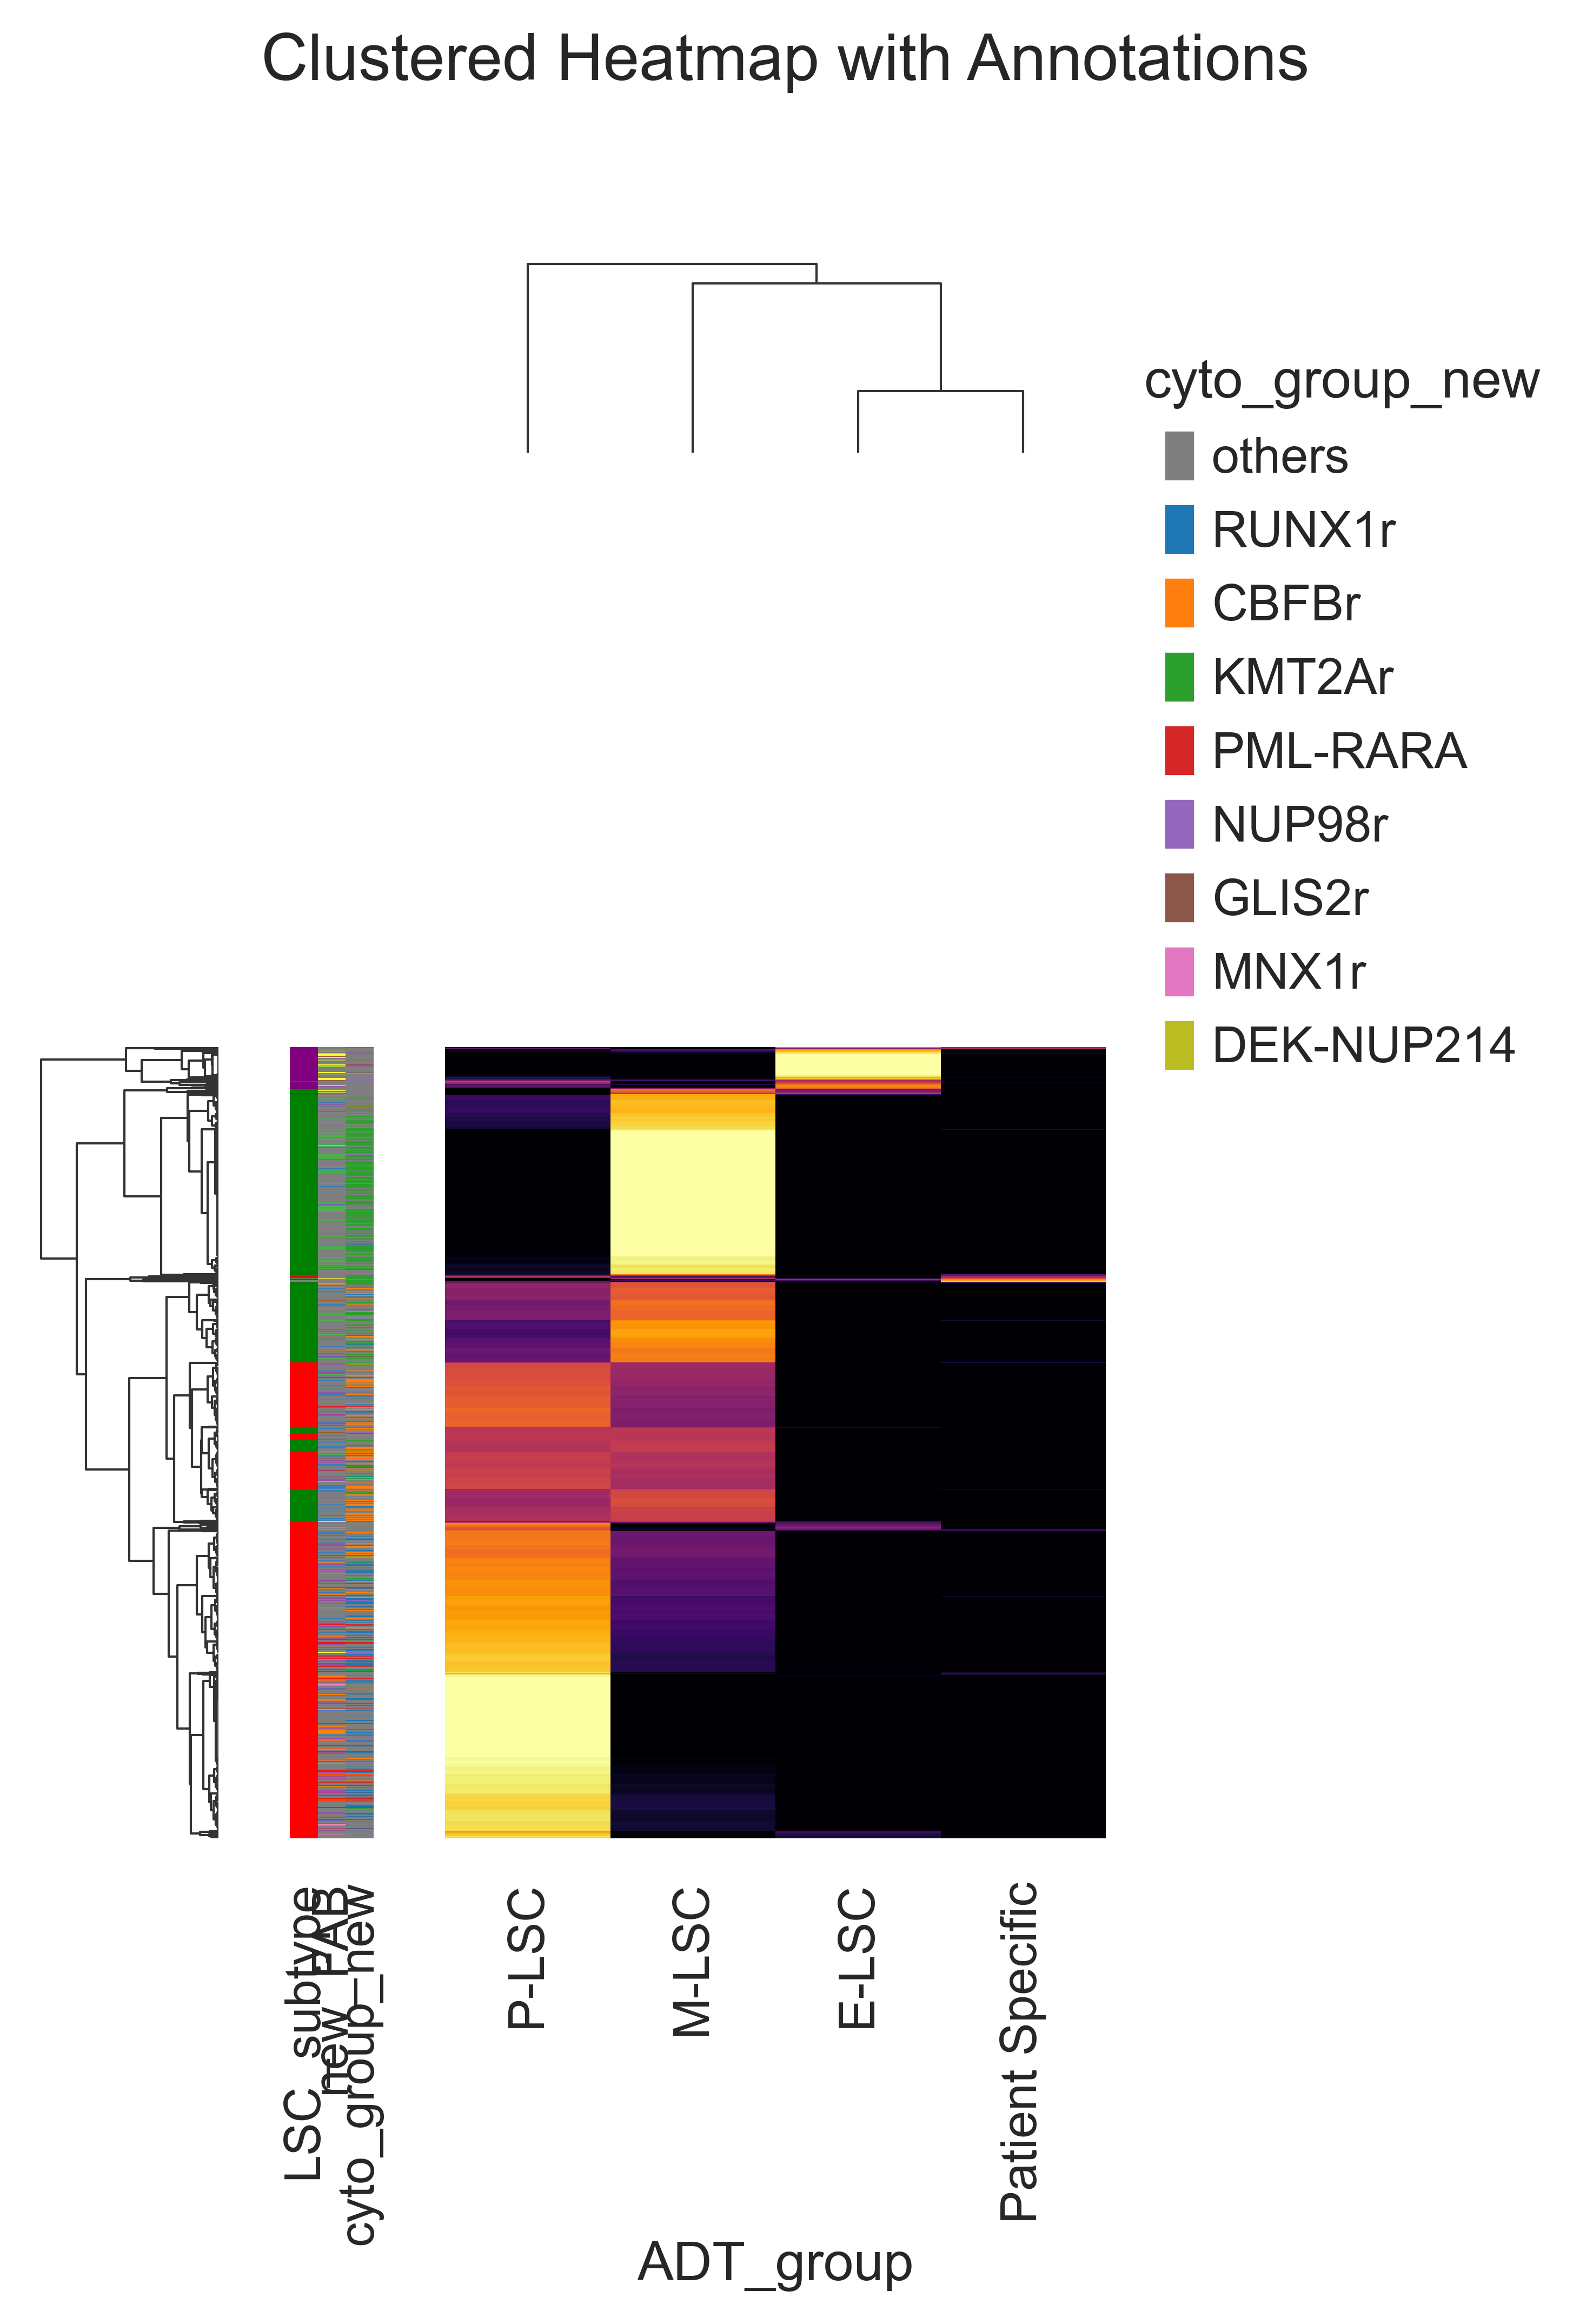

In [25]:
# Align meta_df to filtered df_props
filtered_df = df_props
meta_filtered = meta_df.loc[filtered_df.index]

# Check required columns
assert all(col in meta_filtered.columns for col in ["LSC_subtype","new_FAB", "cyto_group_new"]), "Missing columns in metadata!"

# Select numeric columns for heatmap
numeric_df = filtered_df.select_dtypes(include=[float, int])

# Call the function
plot_clustered_heatmap_with_annotations(
    numeric_df,
    metadata_df=meta_filtered,
    group_cols=["LSC_subtype","new_FAB","cyto_group_new"]
)


/var/folders/k9/hldft9d917ld0845xc2j18040000gp/T/ipykernel_99620/2503123534.py:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=plot_data, x=categorical_col, y=gene_name, palette=palette, showfliers=False)



Kruskal-Wallis H-test results:
p-value: 8.03e-47

Pairwise comparisons (Mann-Whitney U test):
E-LSC enriched_vs_M-LSC enriched: p=3.88e-44
E-LSC enriched_vs_P-LSC enriched: p=2.20e-37
M-LSC enriched_vs_P-LSC enriched: p=1.37e-07
Figure saved to: /Users/sina.kanannejad/Desktop/samplebsample/Paper_Figs/Figs/Targets/Target_cohort/CLEC12A_LSC_clus.pdf


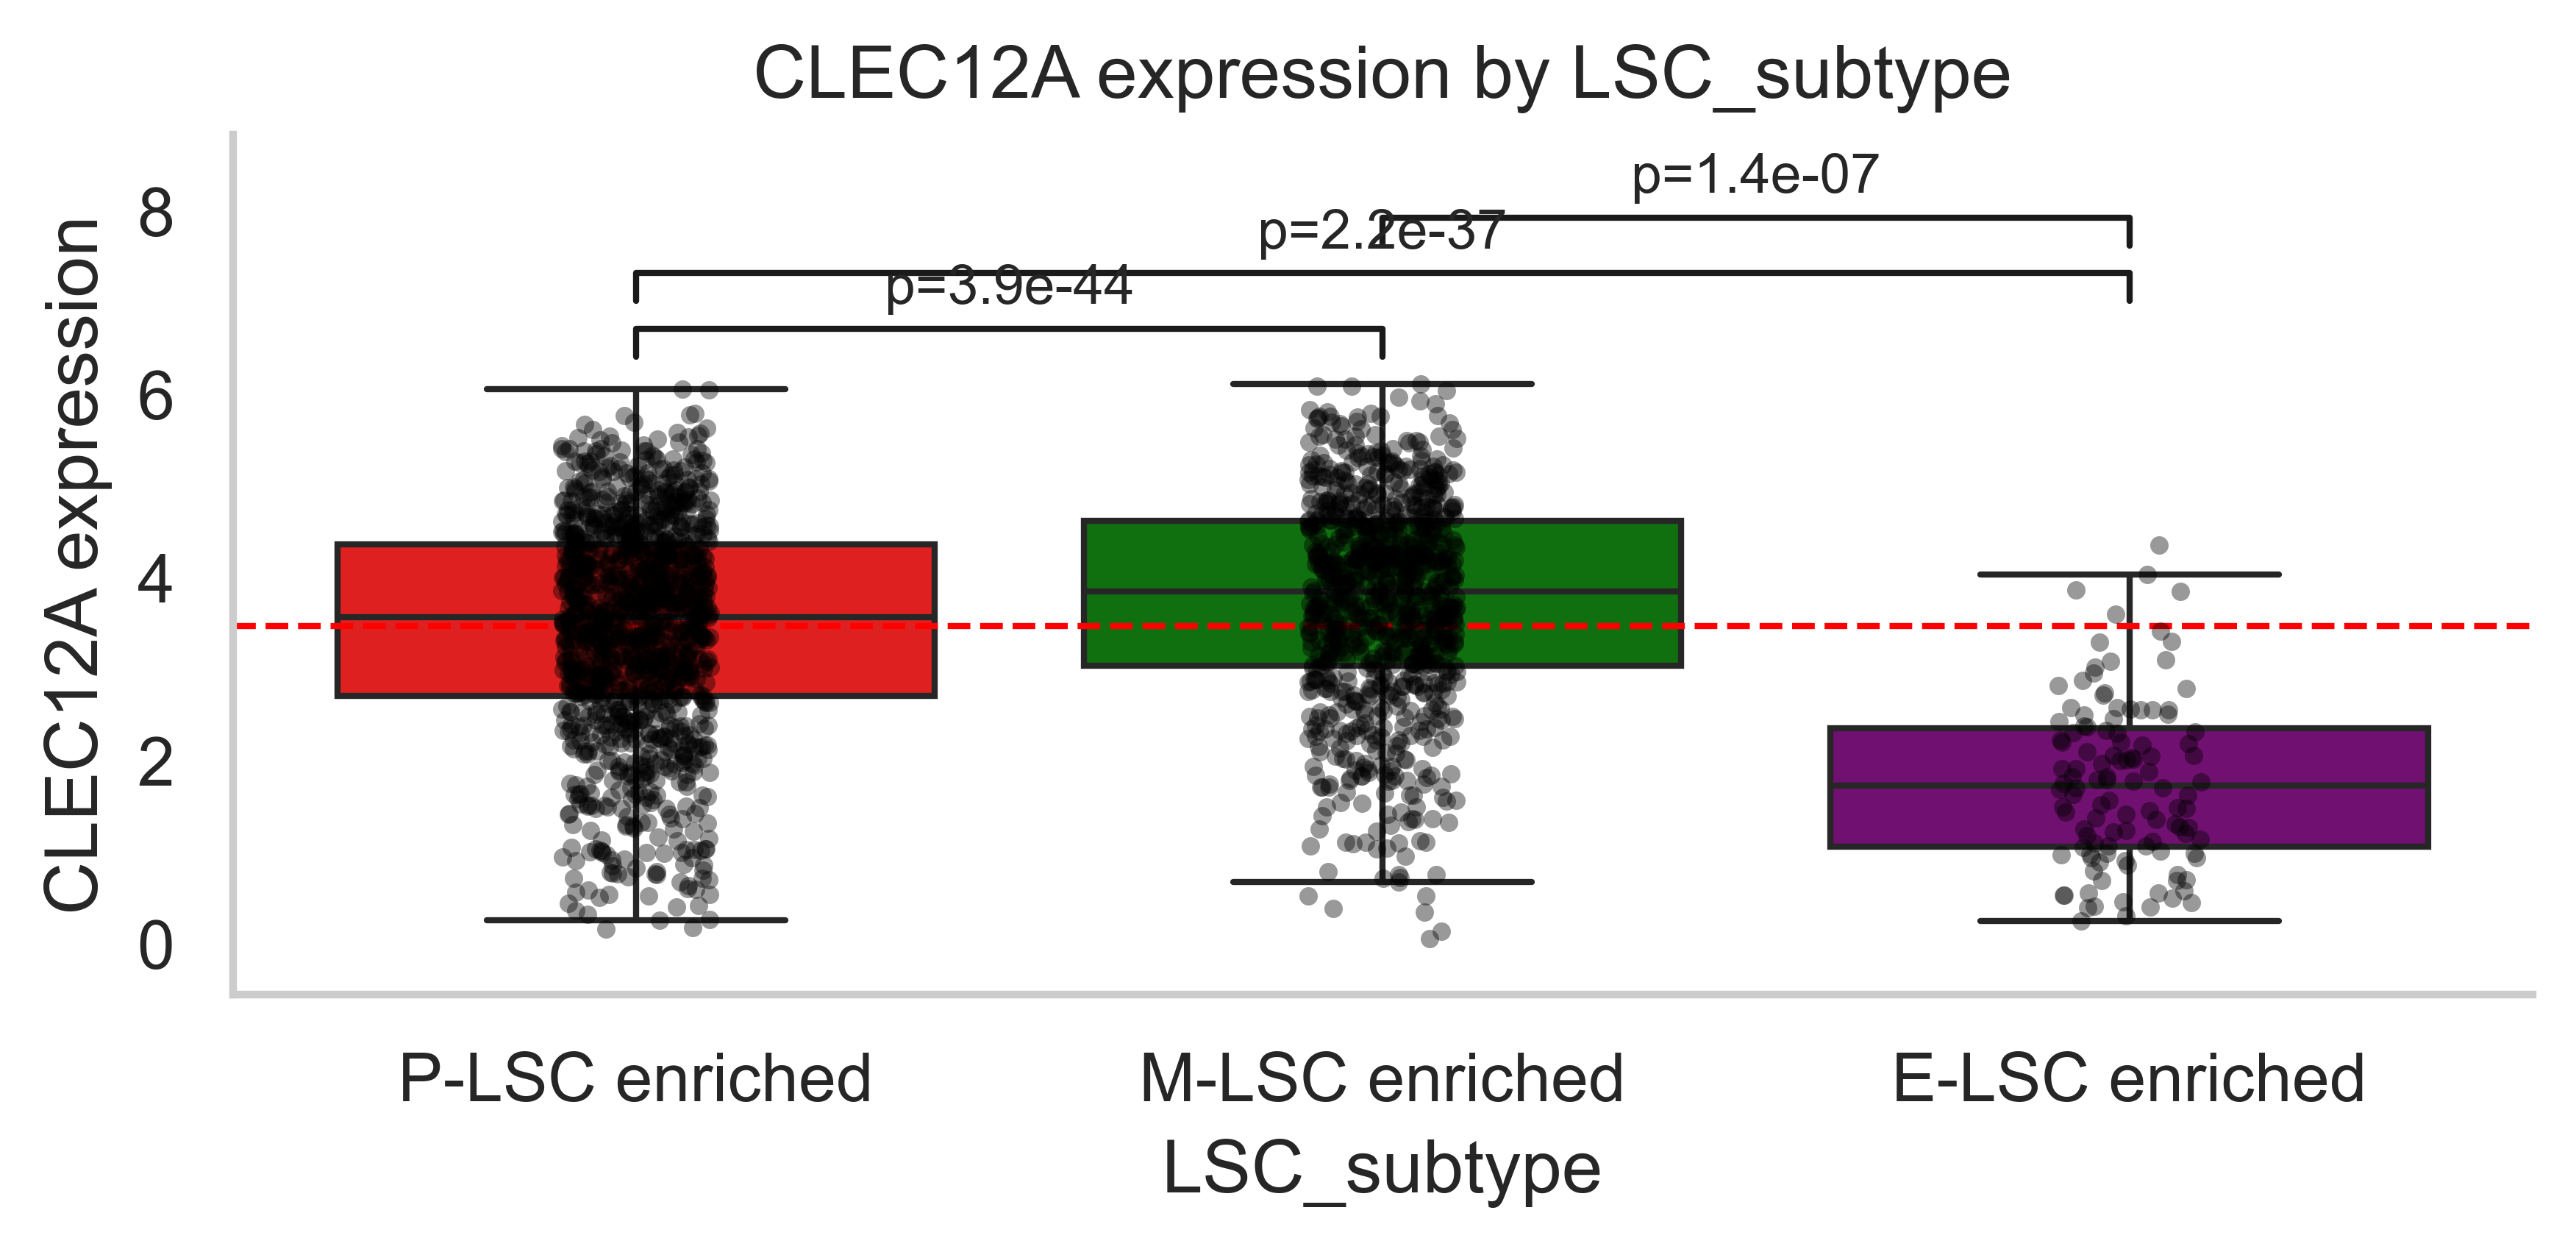

/var/folders/k9/hldft9d917ld0845xc2j18040000gp/T/ipykernel_99620/2503123534.py:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=plot_data, x=categorical_col, y=gene_name, palette=palette, showfliers=False)



Kruskal-Wallis H-test results:
p-value: 6.26e-14

Pairwise comparisons (Mann-Whitney U test):
E-LSC enriched_vs_M-LSC enriched: p=2.40e-01
E-LSC enriched_vs_P-LSC enriched: p=1.33e-04
M-LSC enriched_vs_P-LSC enriched: p=1.53e-13
Figure saved to: /Users/sina.kanannejad/Desktop/samplebsample/Paper_Figs/Figs/Targets/Target_cohort/CD84_LSC_clus.pdf


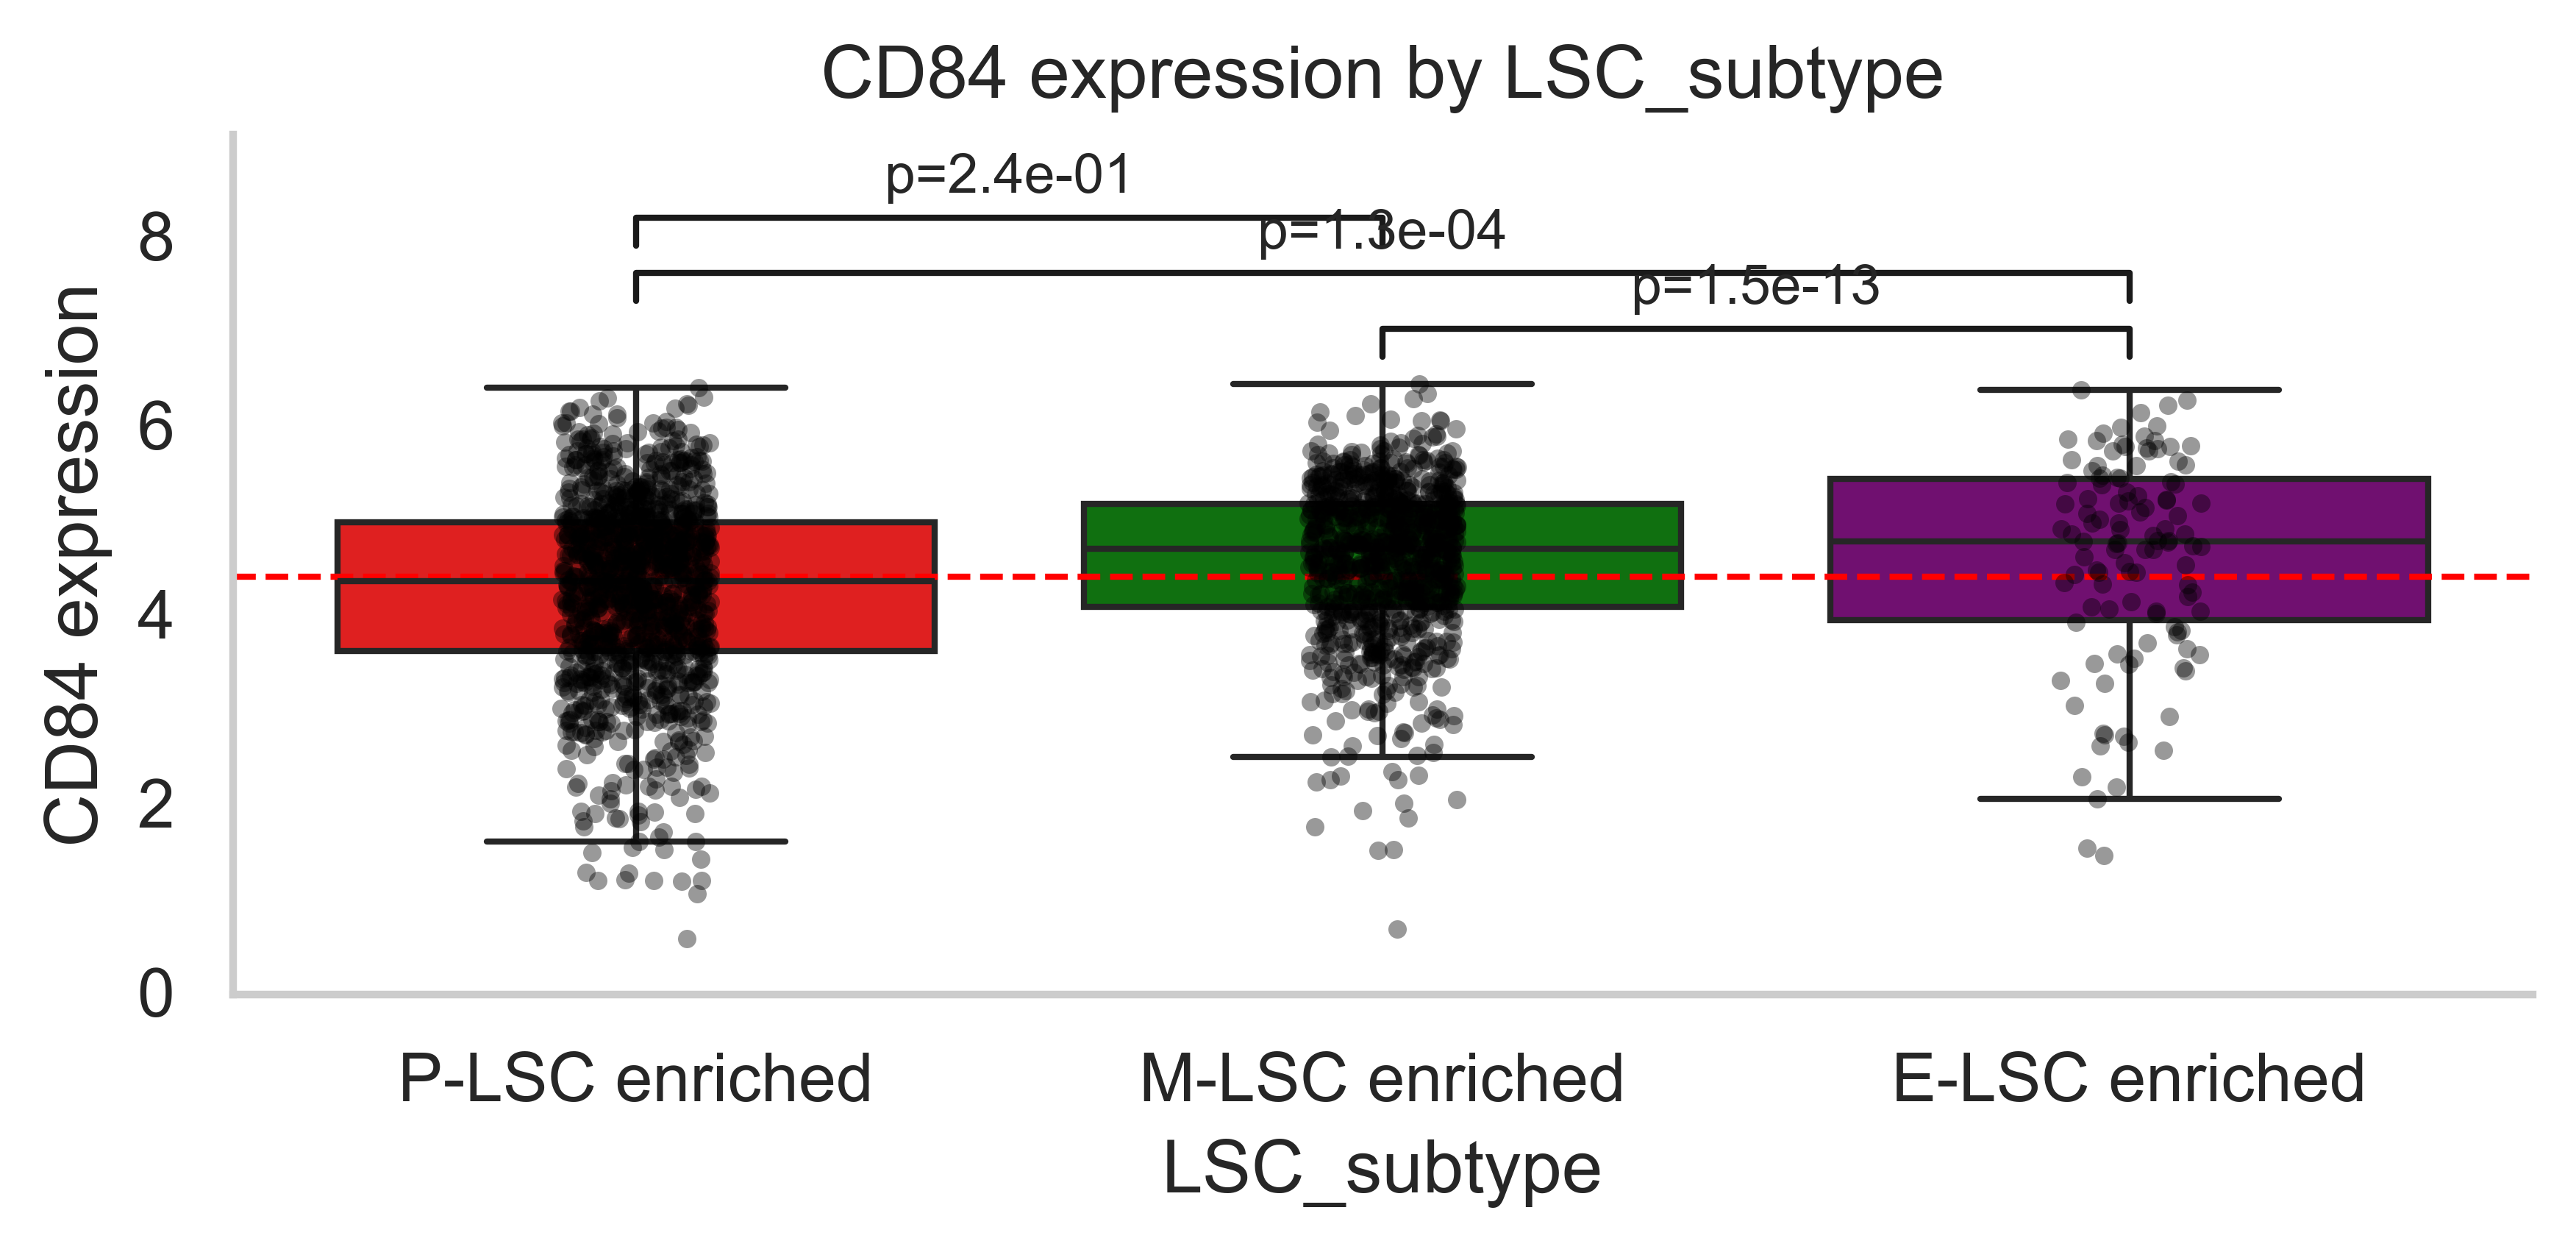

{'kruskal_wallis': {'statistic': np.float64(60.80298253873207),
  'pvalue': np.float64(6.263255090967679e-14)},
 'E-LSC enriched_vs_M-LSC enriched': {'statistic': np.float64(51789.0),
  'pvalue': np.float64(0.24029848360408657)},
 'E-LSC enriched_vs_P-LSC enriched': {'statistic': np.float64(79616.0),
  'pvalue': np.float64(0.00013315152235651479)},
 'M-LSC enriched_vs_P-LSC enriched': {'statistic': np.float64(582707.0),
  'pvalue': np.float64(1.5264611392421308e-13)}}

In [38]:
plot_boxplot_with_stats_gene(target_new_clean[~target_new_clean.obs["LSC_subtype"].isin(["Patient Specific"])], 
categorical_col = "LSC_subtype", gene_name = "CLEC12A", figsize = (6,3),palette = colors_LSC, yline = np.mean(target_new_clean[:,"CLEC12A"].X),
save_path = "/CLEC12A_LSC_clus.pdf",
 show_all_pairs = True)

plot_boxplot_with_stats_gene(target_new_clean[~target_new_clean.obs["LSC_subtype"].isin(["Patient Specific"])], 
categorical_col = "LSC_subtype", gene_name = "CD84", figsize = (6,3),palette = colors_LSC, yline = np.mean(target_new_clean[:,"CD84"].X),
save_path = "/CD84_LSC_clus.pdf",
 show_all_pairs = True)


In [35]:
target_new_clean.obs["cyto_lsc_sub"] = target_new_clean.obs["cyto_group_new"].astype("str") + target_new_clean.obs["LSC_subtype"].astype("str")
label_high_low_gene_expression(target_new_clean, "CLEC12A")
label_high_low_gene_expression(target_new_clean, "CD84")
label_high_low_gene_expression(target_new_clean, "IL1RAP")
label_high_low_gene_expression(target_new_clean, "NCAM1")

target_new_clean.obs["CLEC12_CD84"] = target_new_clean.obs["CLEC12A_high_low"].astype("str") + target_new_clean.obs["CD84_high_low"].astype("str")
target_new_clean.obs["CLEC12_CD84_IL1RAP"] = target_new_clean.obs["CLEC12A_high_low"].astype("str") + target_new_clean.obs["CD84_high_low"].astype("str") + target_new_clean.obs["IL1RAP_high_low"].astype("str")

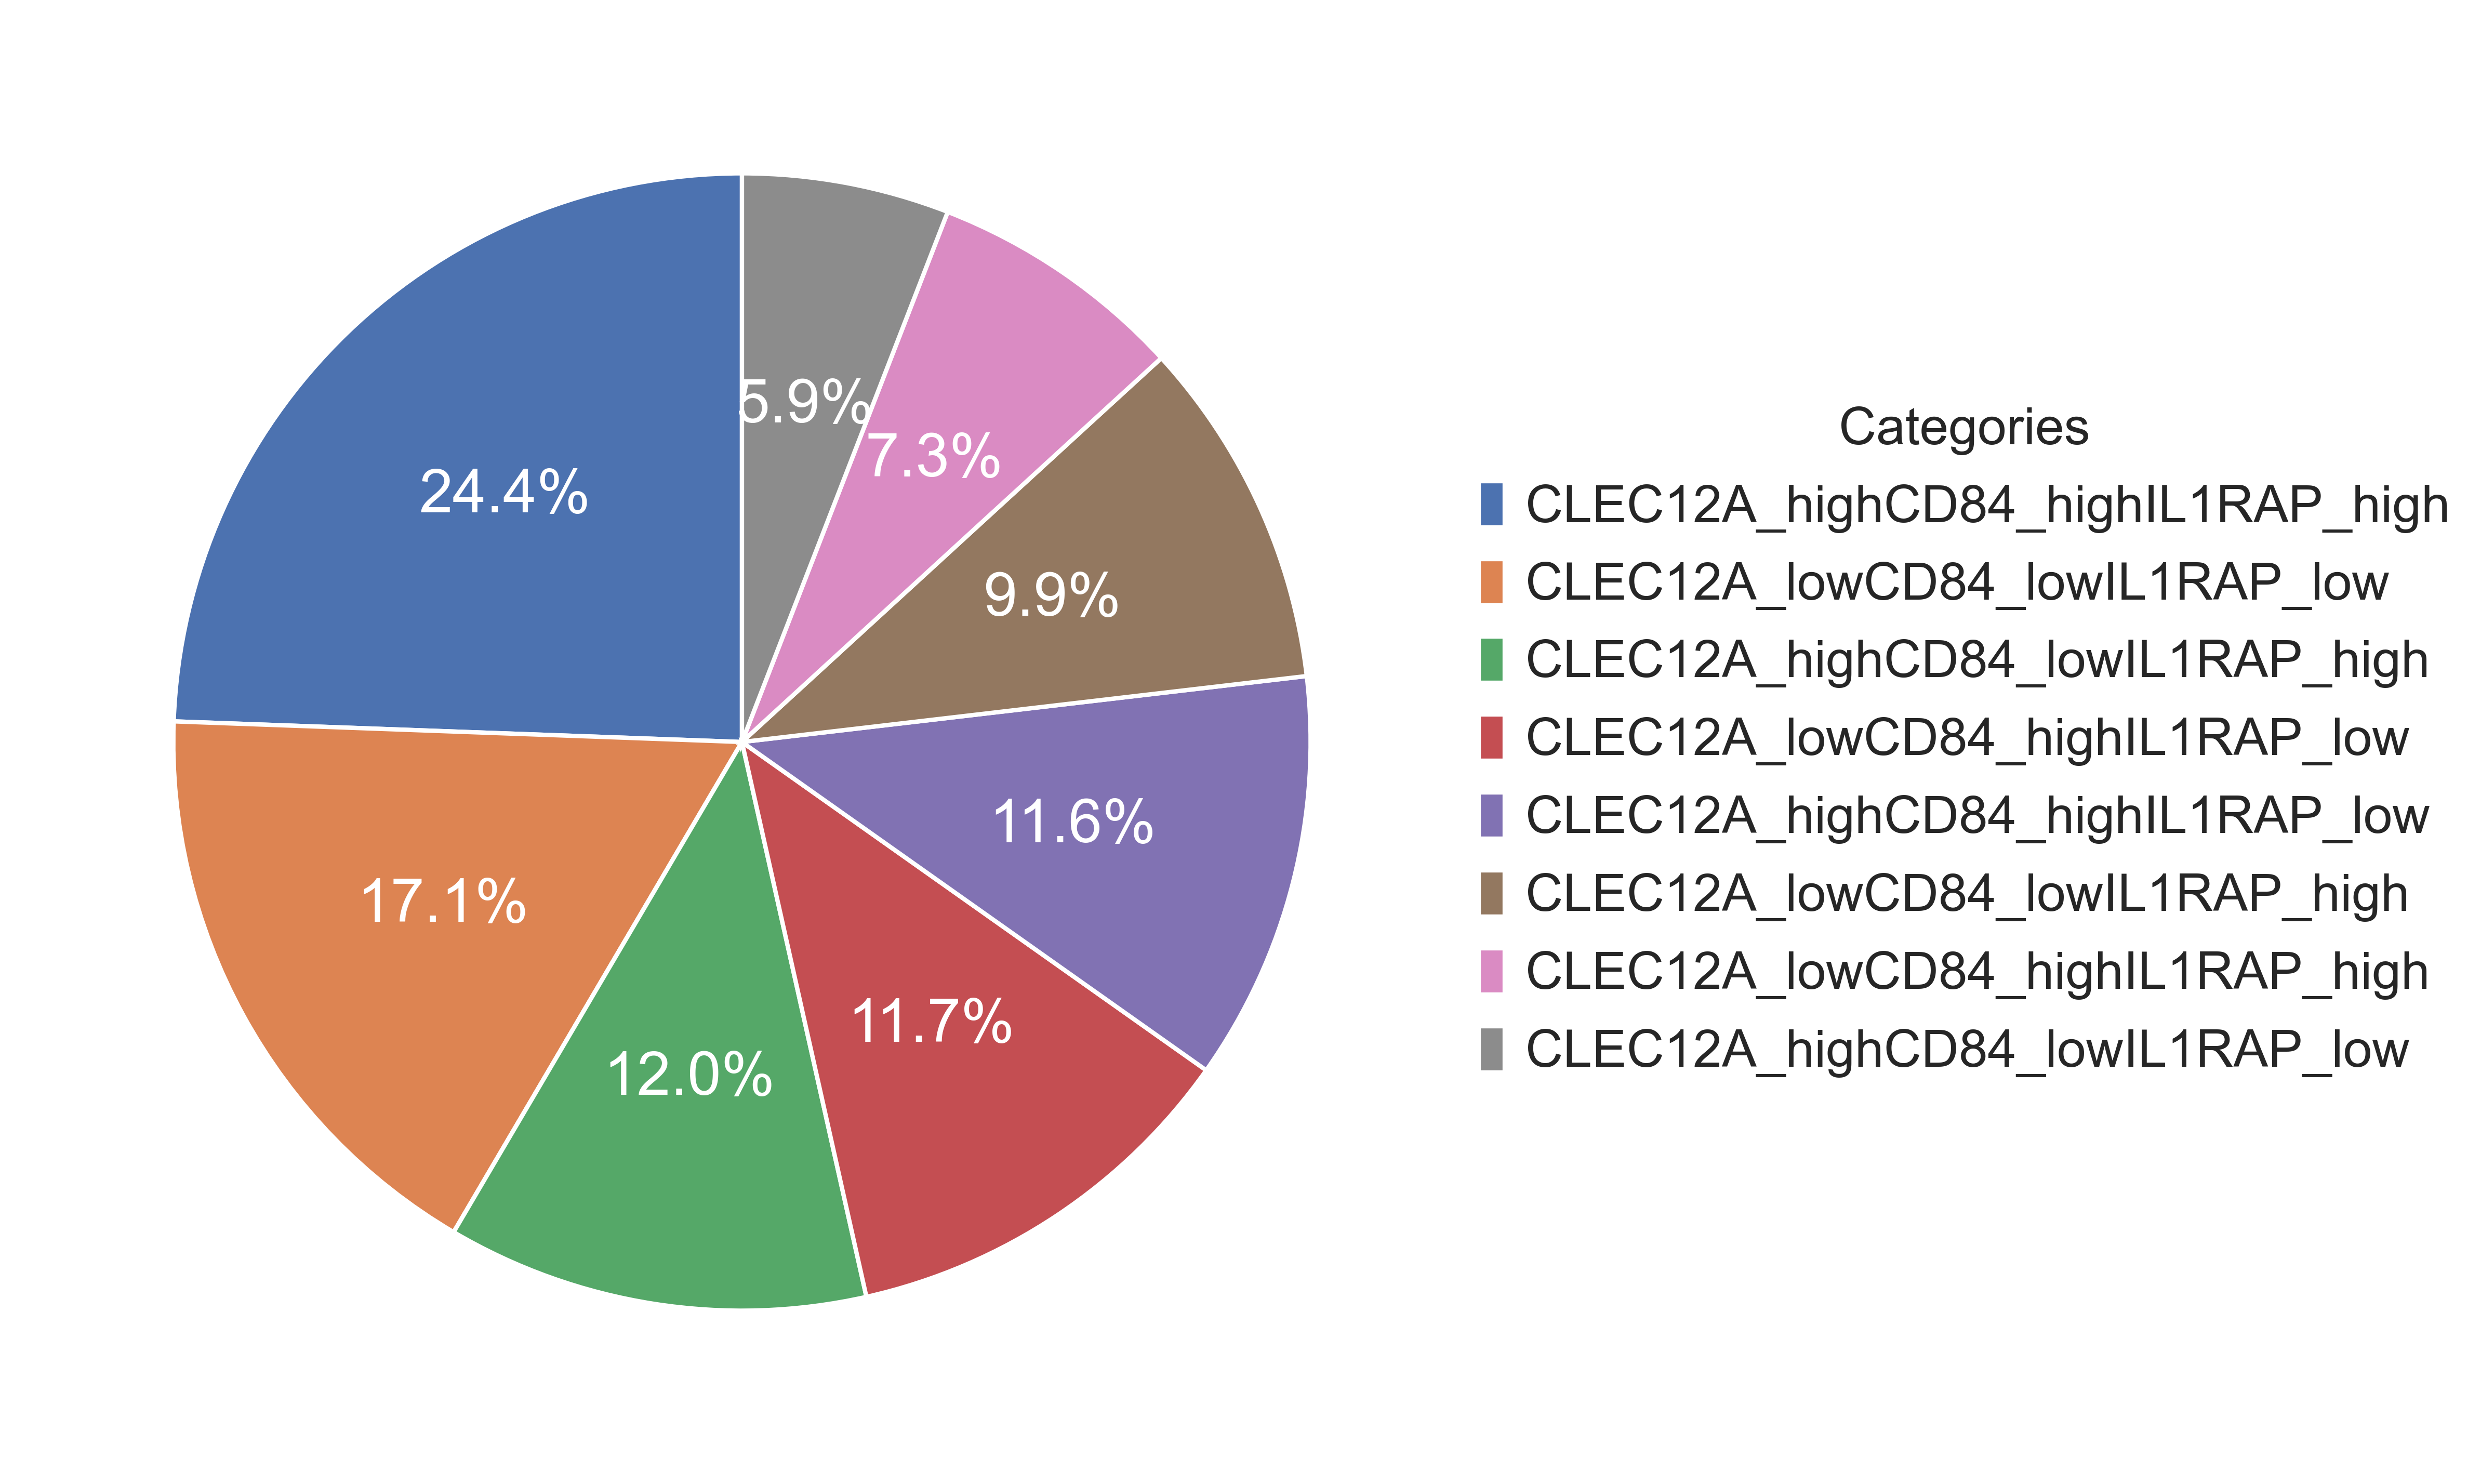

In [40]:

# Filter and group
filtered_df = target_new_clean.obs

# Count values of CLEC12_CD84_IL1RAP (excluding 'others' in cyto_new)
counts = filtered_df["CLEC12_CD84_IL1RAP"][~filtered_df["cyto_new"].isin(["others"])].value_counts()

# Keep only counts > 2
counts = counts[counts > 2]

# Create pie chart
fig, ax = plt.subplots(figsize=(6, 6))
wedges, texts, autotexts = ax.pie(
    counts,
    labels=None,  # No labels on slices
    autopct='%1.1f%%',  # Show percentages
    startangle=90,
    textprops={'fontsize': 14, 'color': 'white'}  # White text inside
)

# Add legend instead of labels on slices
ax.legend(
    wedges,
    counts.index,  # Category names
    title="Categories",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1),
    fontsize=12
)

# Remove y-label
plt.ylabel("")

# Save figure
plt.savefig("/Pie_all_threetargets.pdf", bbox_inches='tight')
plt.show()


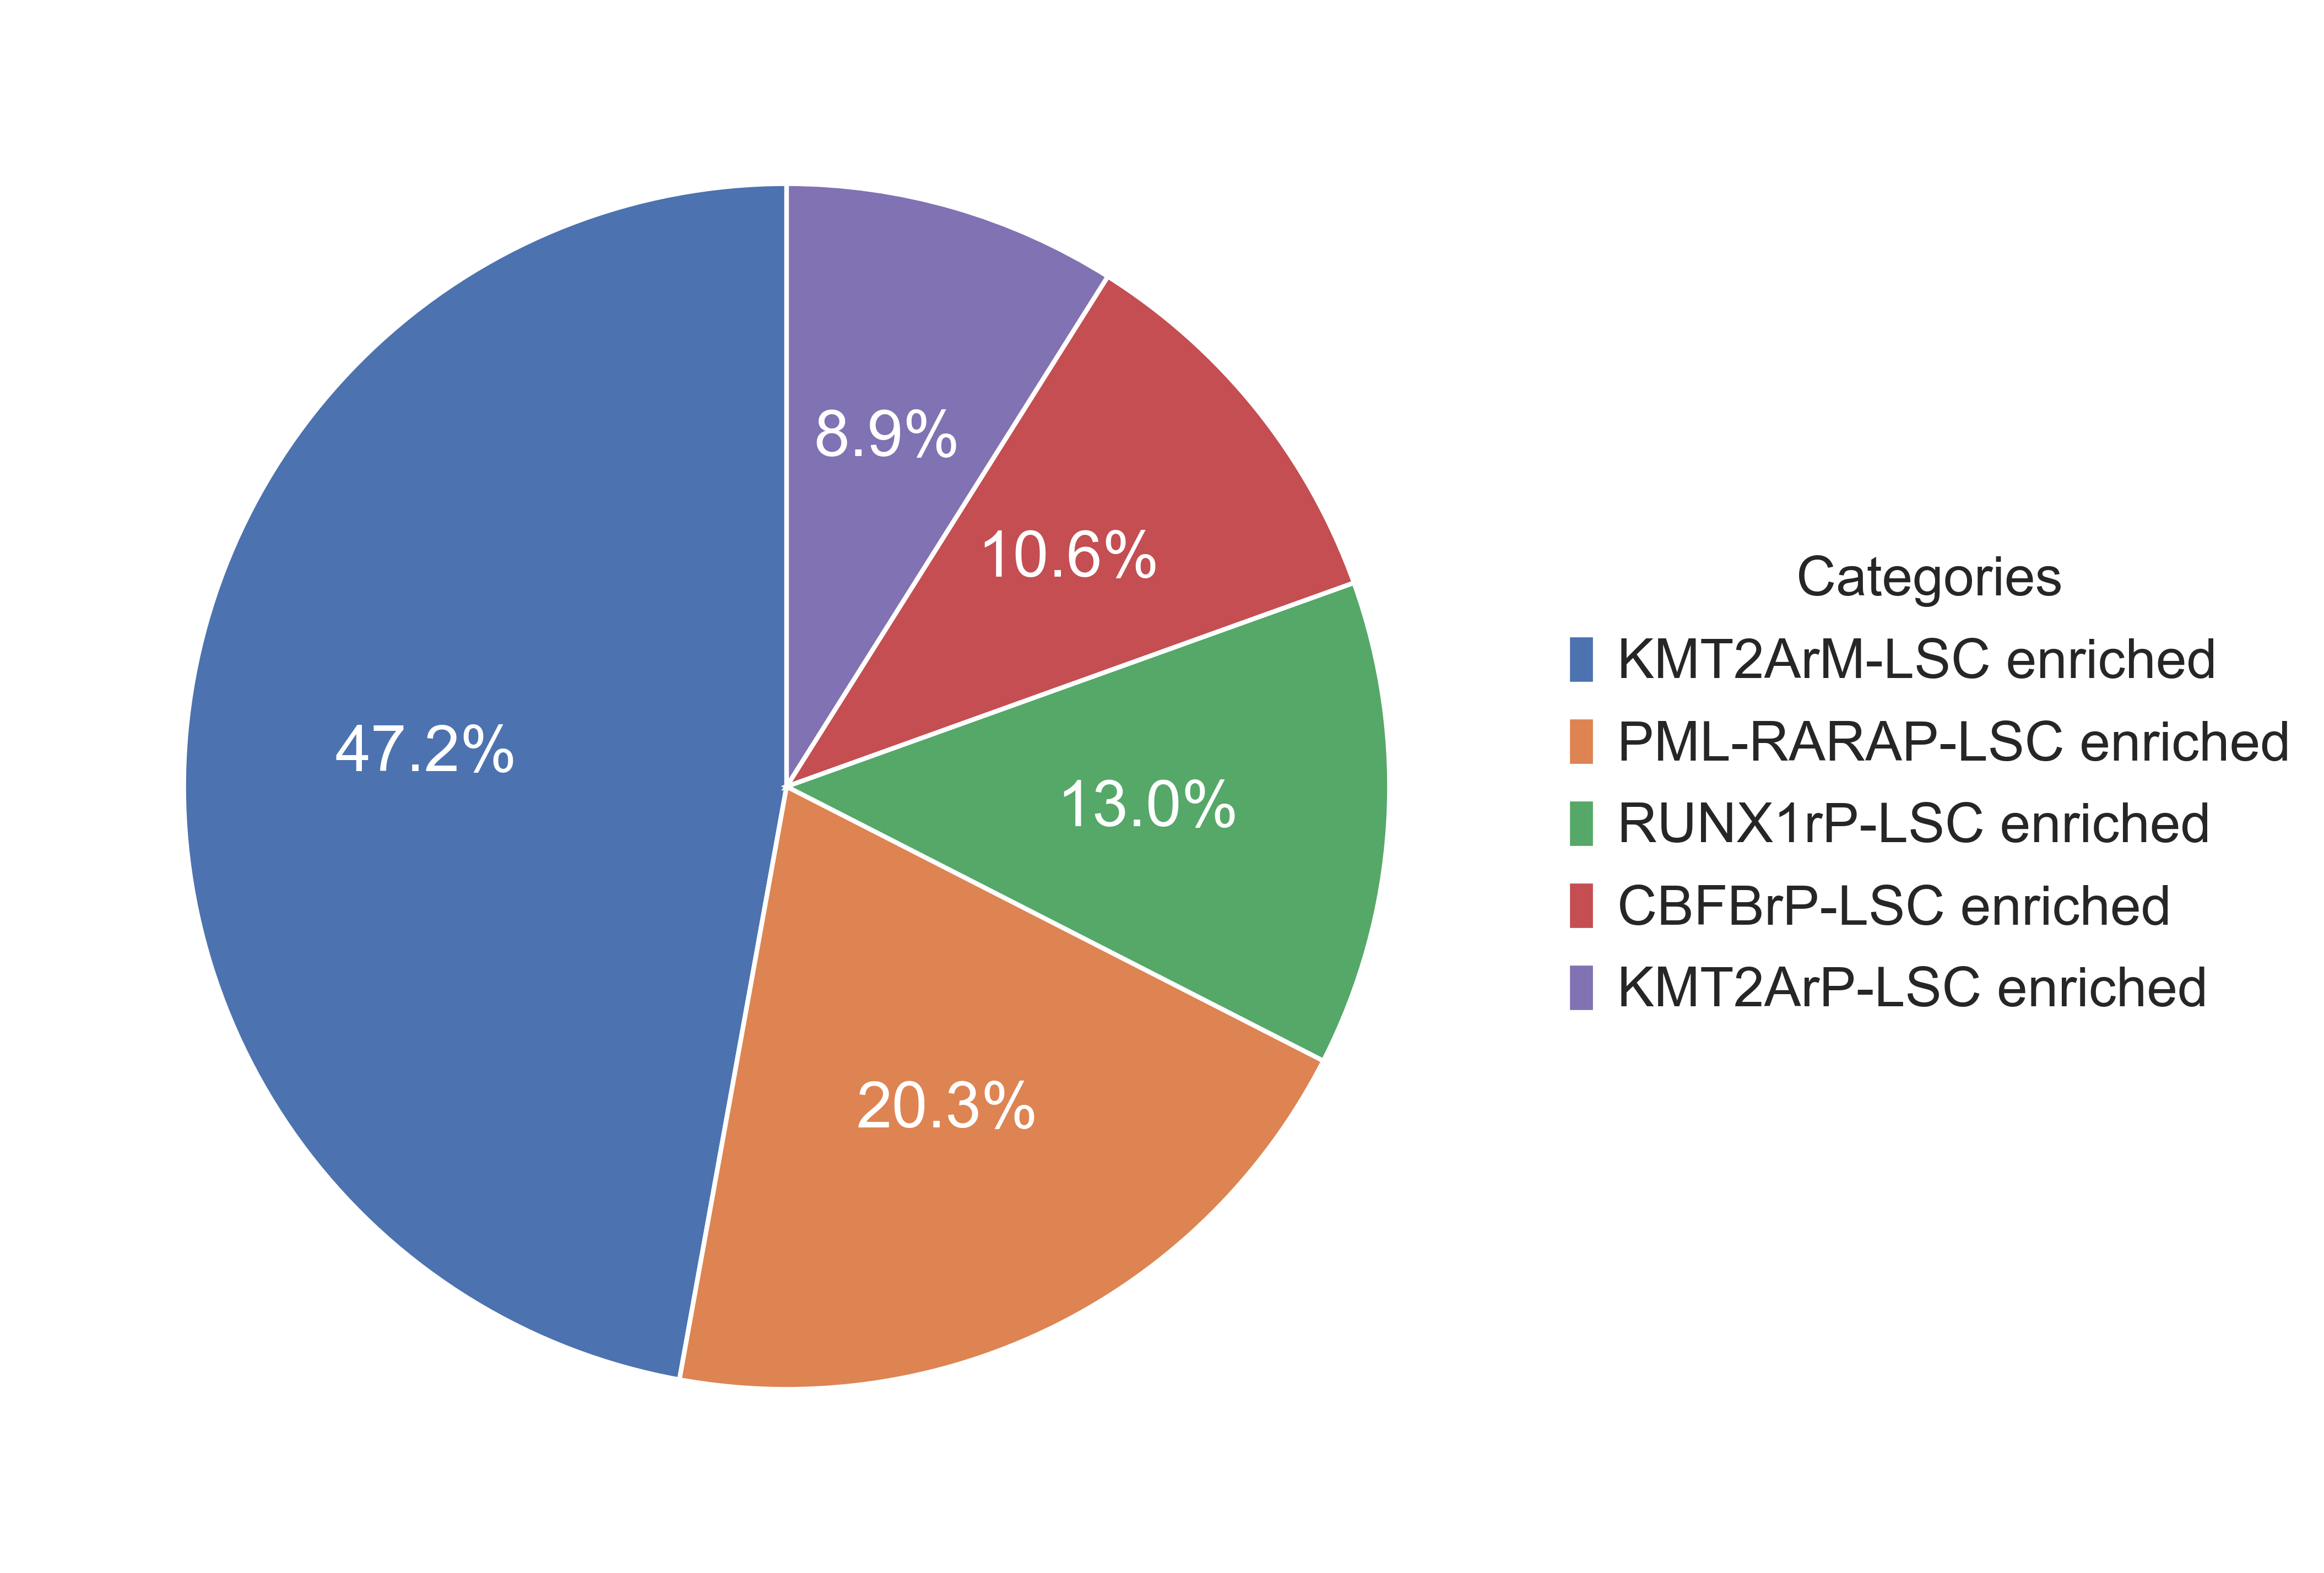

In [53]:


# Filter and group
filtered_df = target_new_clean.obs[target_new_clean.obs["CLEC12_CD84_IL1RAP"] == "CLEC12A_lowCD84_lowIL1RAP_low"]

# Count values of CLEC12_CD84_IL1RAP (excluding 'others' in cyto_new)
counts = filtered_df["cyto_lsc_sub"][~filtered_df["cyto_group_new"].isin(["others"])].value_counts()

# Keep only counts > 2
counts = counts[counts > 5]

# Create pie chart
fig, ax = plt.subplots(figsize=(6, 6))
wedges, texts, autotexts = ax.pie(
    counts,
    labels=None,  # No labels on slices
    autopct='%1.1f%%',  # Show percentages
    startangle=90,
    textprops={'fontsize': 14, 'color': 'white'}  # White text inside
)

# Add legend instead of labels on slices
ax.legend(
    wedges,
    counts.index,  # Category names
    title="Categories",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1),
    fontsize=12
)

# Remove y-label
plt.ylabel("")

# Save figure
plt.savefig("/Pie_all_threetargets_cyto.pdf", bbox_inches='tight')
plt.show()


In [81]:
import re

# List of fusion/gene patterns and their short names
fusion_patterns = {
    r"HOX": "HOXr",
    r"GLIS": "GLISr",
    r"GATA": "GATAr",
    r"MNX1r": "MNX1r",
    r"KMT2A": "KMT2Ar",
    r"CBFBr": "CBFBr",
    r"RUNX1r": "RUNX1r",
    r"NUP98": "NUP98r",
    r"KAT6A": "KAT6A",
    r"FUS": "FUS_ERG",
    r"NPM1": "NPM1",
    r"MECOM": "MECOM",
    r"PICALM": "PICALM_MLLT10",
    r"PML::RARA": "PML_RARA",
    r"UBTF": "UBTF",
    r"RBM15": "RBM15r",
    r"CEBPA": "CEBPA",
    r"DEK-NUP214": "DEK-NUP214"
}

def classify_with_lsc(row):
    cyto_text = str(row["cyto_group_new"])
    lsc = str(row["LSC_subtype"]) if pd.notna(row["LSC_subtype"]) else ""

    # Match fusion pattern
    for pattern, short_name in fusion_patterns.items():
        if re.search(pattern, cyto_text):
            # Attach LSC subtype if available
            if lsc in ["M-LSC enriched", "P-LSC enriched", "E-LSC enriched"]:
                return f"{short_name}_{lsc}"
            else:
                return short_name

    return "others"

# Apply classification
target_new_clean.obs["cyto_new_group"] = target_new_clean.obs.apply(classify_with_lsc, axis=1)


In [55]:
list(target_new_clean.obs["cyto_new_group"].value_counts()[target_new_clean.obs["cyto_new_group"].value_counts()> 2].index)
groups_plot = [
 'KMT2Ar_M-LSC enriched',
 'RUNX1r_P-LSC enriched',
 'CBFBr_P-LSC enriched',
 'CBFBr_M-LSC enriched',
 'KMT2Ar_P-LSC enriched',
 'RUNX1r_M-LSC enriched',
 'NUP98r_P-LSC enriched',
 'NUP98r_M-LSC enriched',
 'GLISr_E-LSC enriched',
 'NUP98r_E-LSC enriched',
 'KMT2Ar_E-LSC enriched',
 'DEK-NUP214_P-LSC enriched']

In [56]:
groups_plot_sorted = [
    'GLISr_E-LSC enriched',
'NUP98r_E-LSC enriched',
'KMT2Ar_E-LSC enriched',
'KMT2Ar_M-LSC enriched',
'CBFBr_M-LSC enriched',
'RUNX1r_M-LSC enriched',
'NUP98r_M-LSC enriched',
'RUNX1r_P-LSC enriched',
'CBFBr_P-LSC enriched',
'KMT2Ar_P-LSC enriched',
'NUP98r_P-LSC enriched',
'DEK-NUP214_P-LSC enriched'
]


/opt/anaconda3/envs/survival/lib/python3.10/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'nucleic.acid.code' as categorical
/opt/anaconda3/envs/survival/lib/python3.10/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'definition' as categorical
/opt/anaconda3/envs/survival/lib/python3.10/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'tumor.definition' as categorical
/opt/anaconda3/envs/survival/lib/python3.10/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'nucleic.acid.description' as categoric

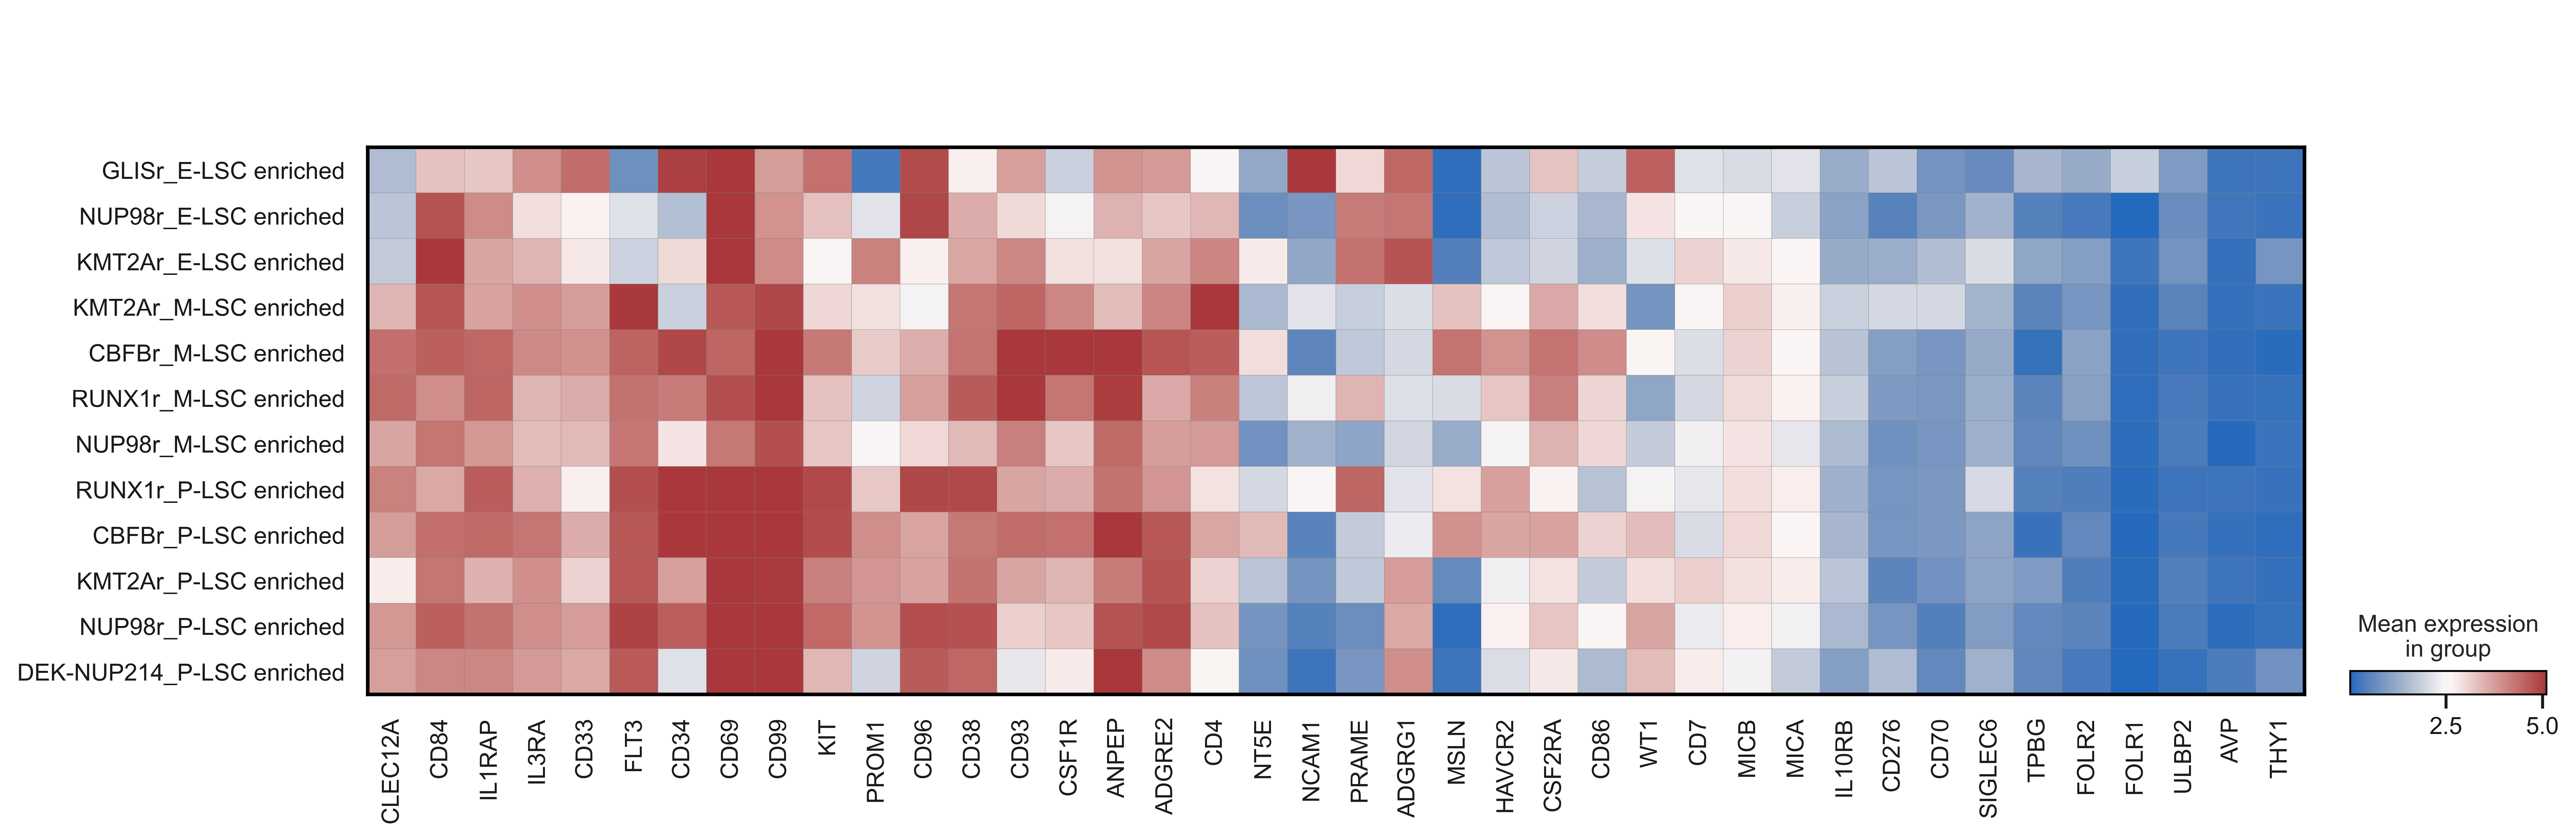

In [58]:
sc.settings.set_figure_params(
    dpi=300,
    facecolor="white",
    frameon=False, fontsize = 12
)

sc.pl.matrixplot(target_new_clean[target_new_clean.obs["cyto_new_group"].isin(groups_plot)], groupby = "cyto_new_group", var_names = ["CLEC12A","CD84","IL1RAP","IL3RA","CD33","FLT3","CD34","CD69","CD99","KIT","PROM1","CD96","CD38","CD93","CSF1R","ANPEP","ADGRE2","CD4","NT5E",
"NCAM1","PRAME","ADGRG1","MSLN", "HAVCR2","CSF2RA","CD86","WT1","CD7","MICB","MICA",
"IL10RB","CD276","CD70","SIGLEC6","TPBG","FOLR2","FOLR1","ULBP2","AVP", "THY1"],vmax = 5.1,
 cmap = "vlag", swap_axes = False, categories_order = groups_plot_sorted, save = "targets_TARGET.pdf")



/opt/anaconda3/envs/survival/lib/python3.10/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'nucleic.acid.code' as categorical
/opt/anaconda3/envs/survival/lib/python3.10/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'definition' as categorical
/opt/anaconda3/envs/survival/lib/python3.10/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'tumor.definition' as categorical
/opt/anaconda3/envs/survival/lib/python3.10/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'nucleic.acid.description' as categoric

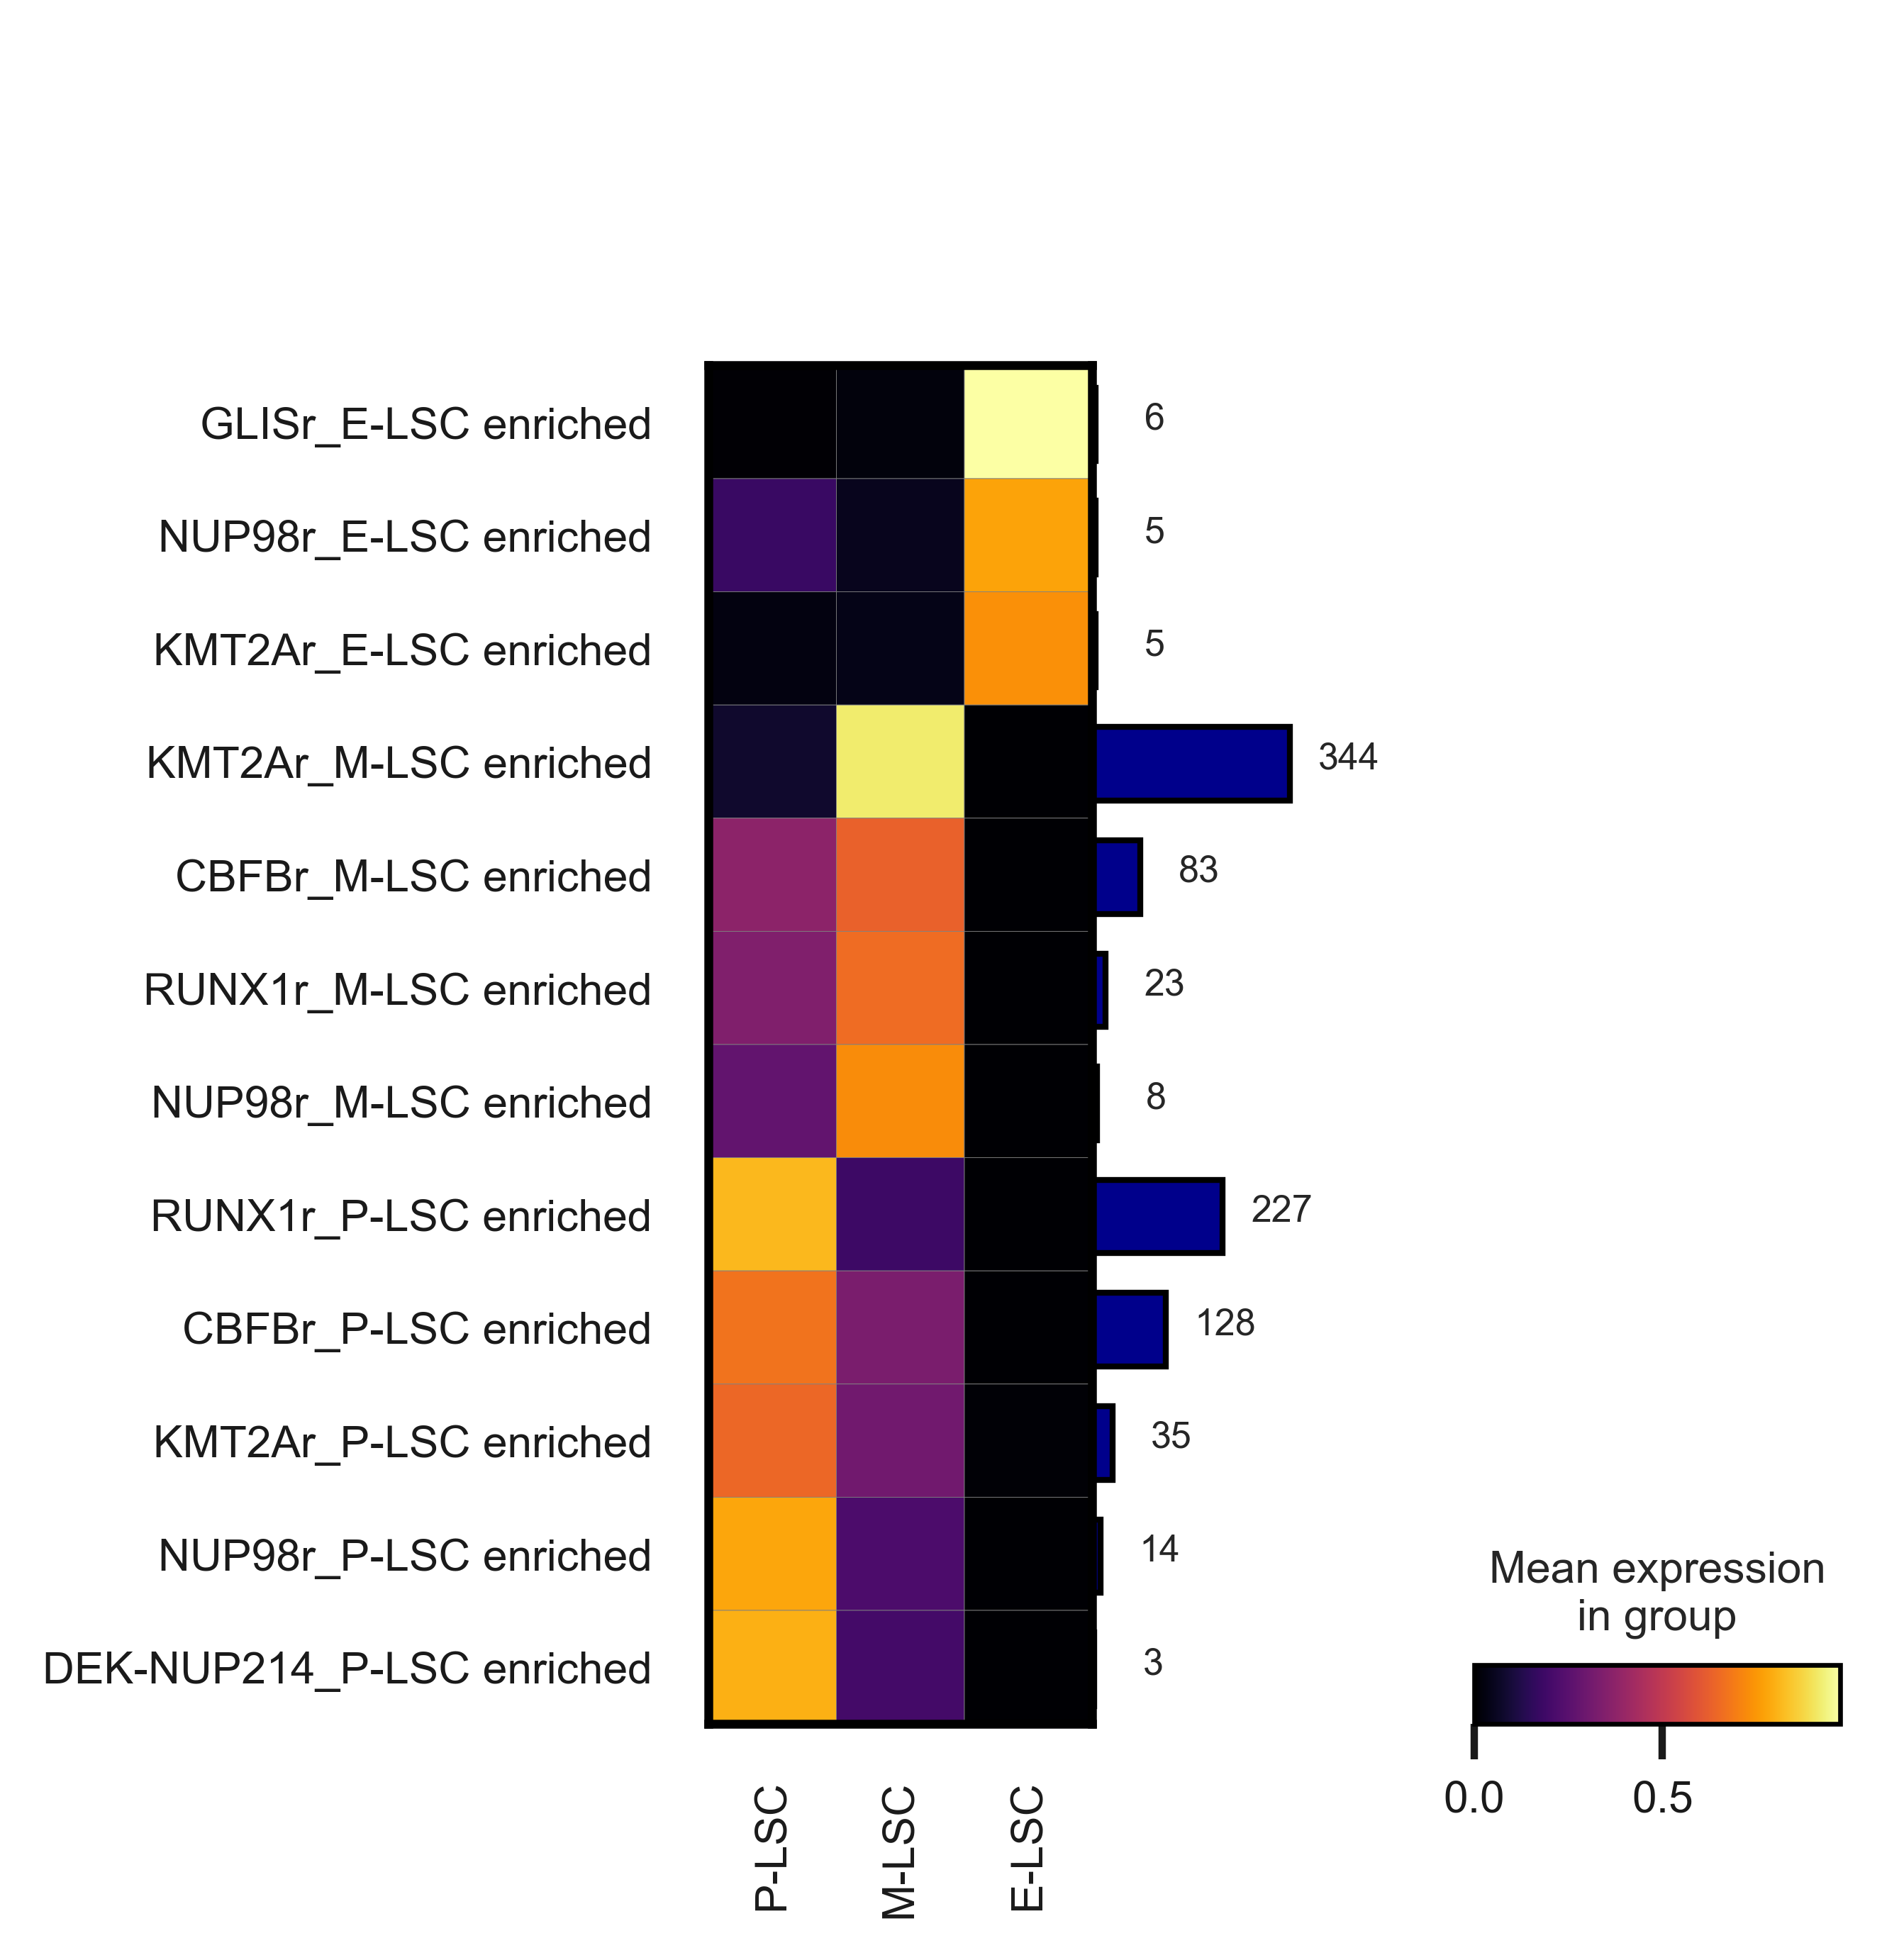

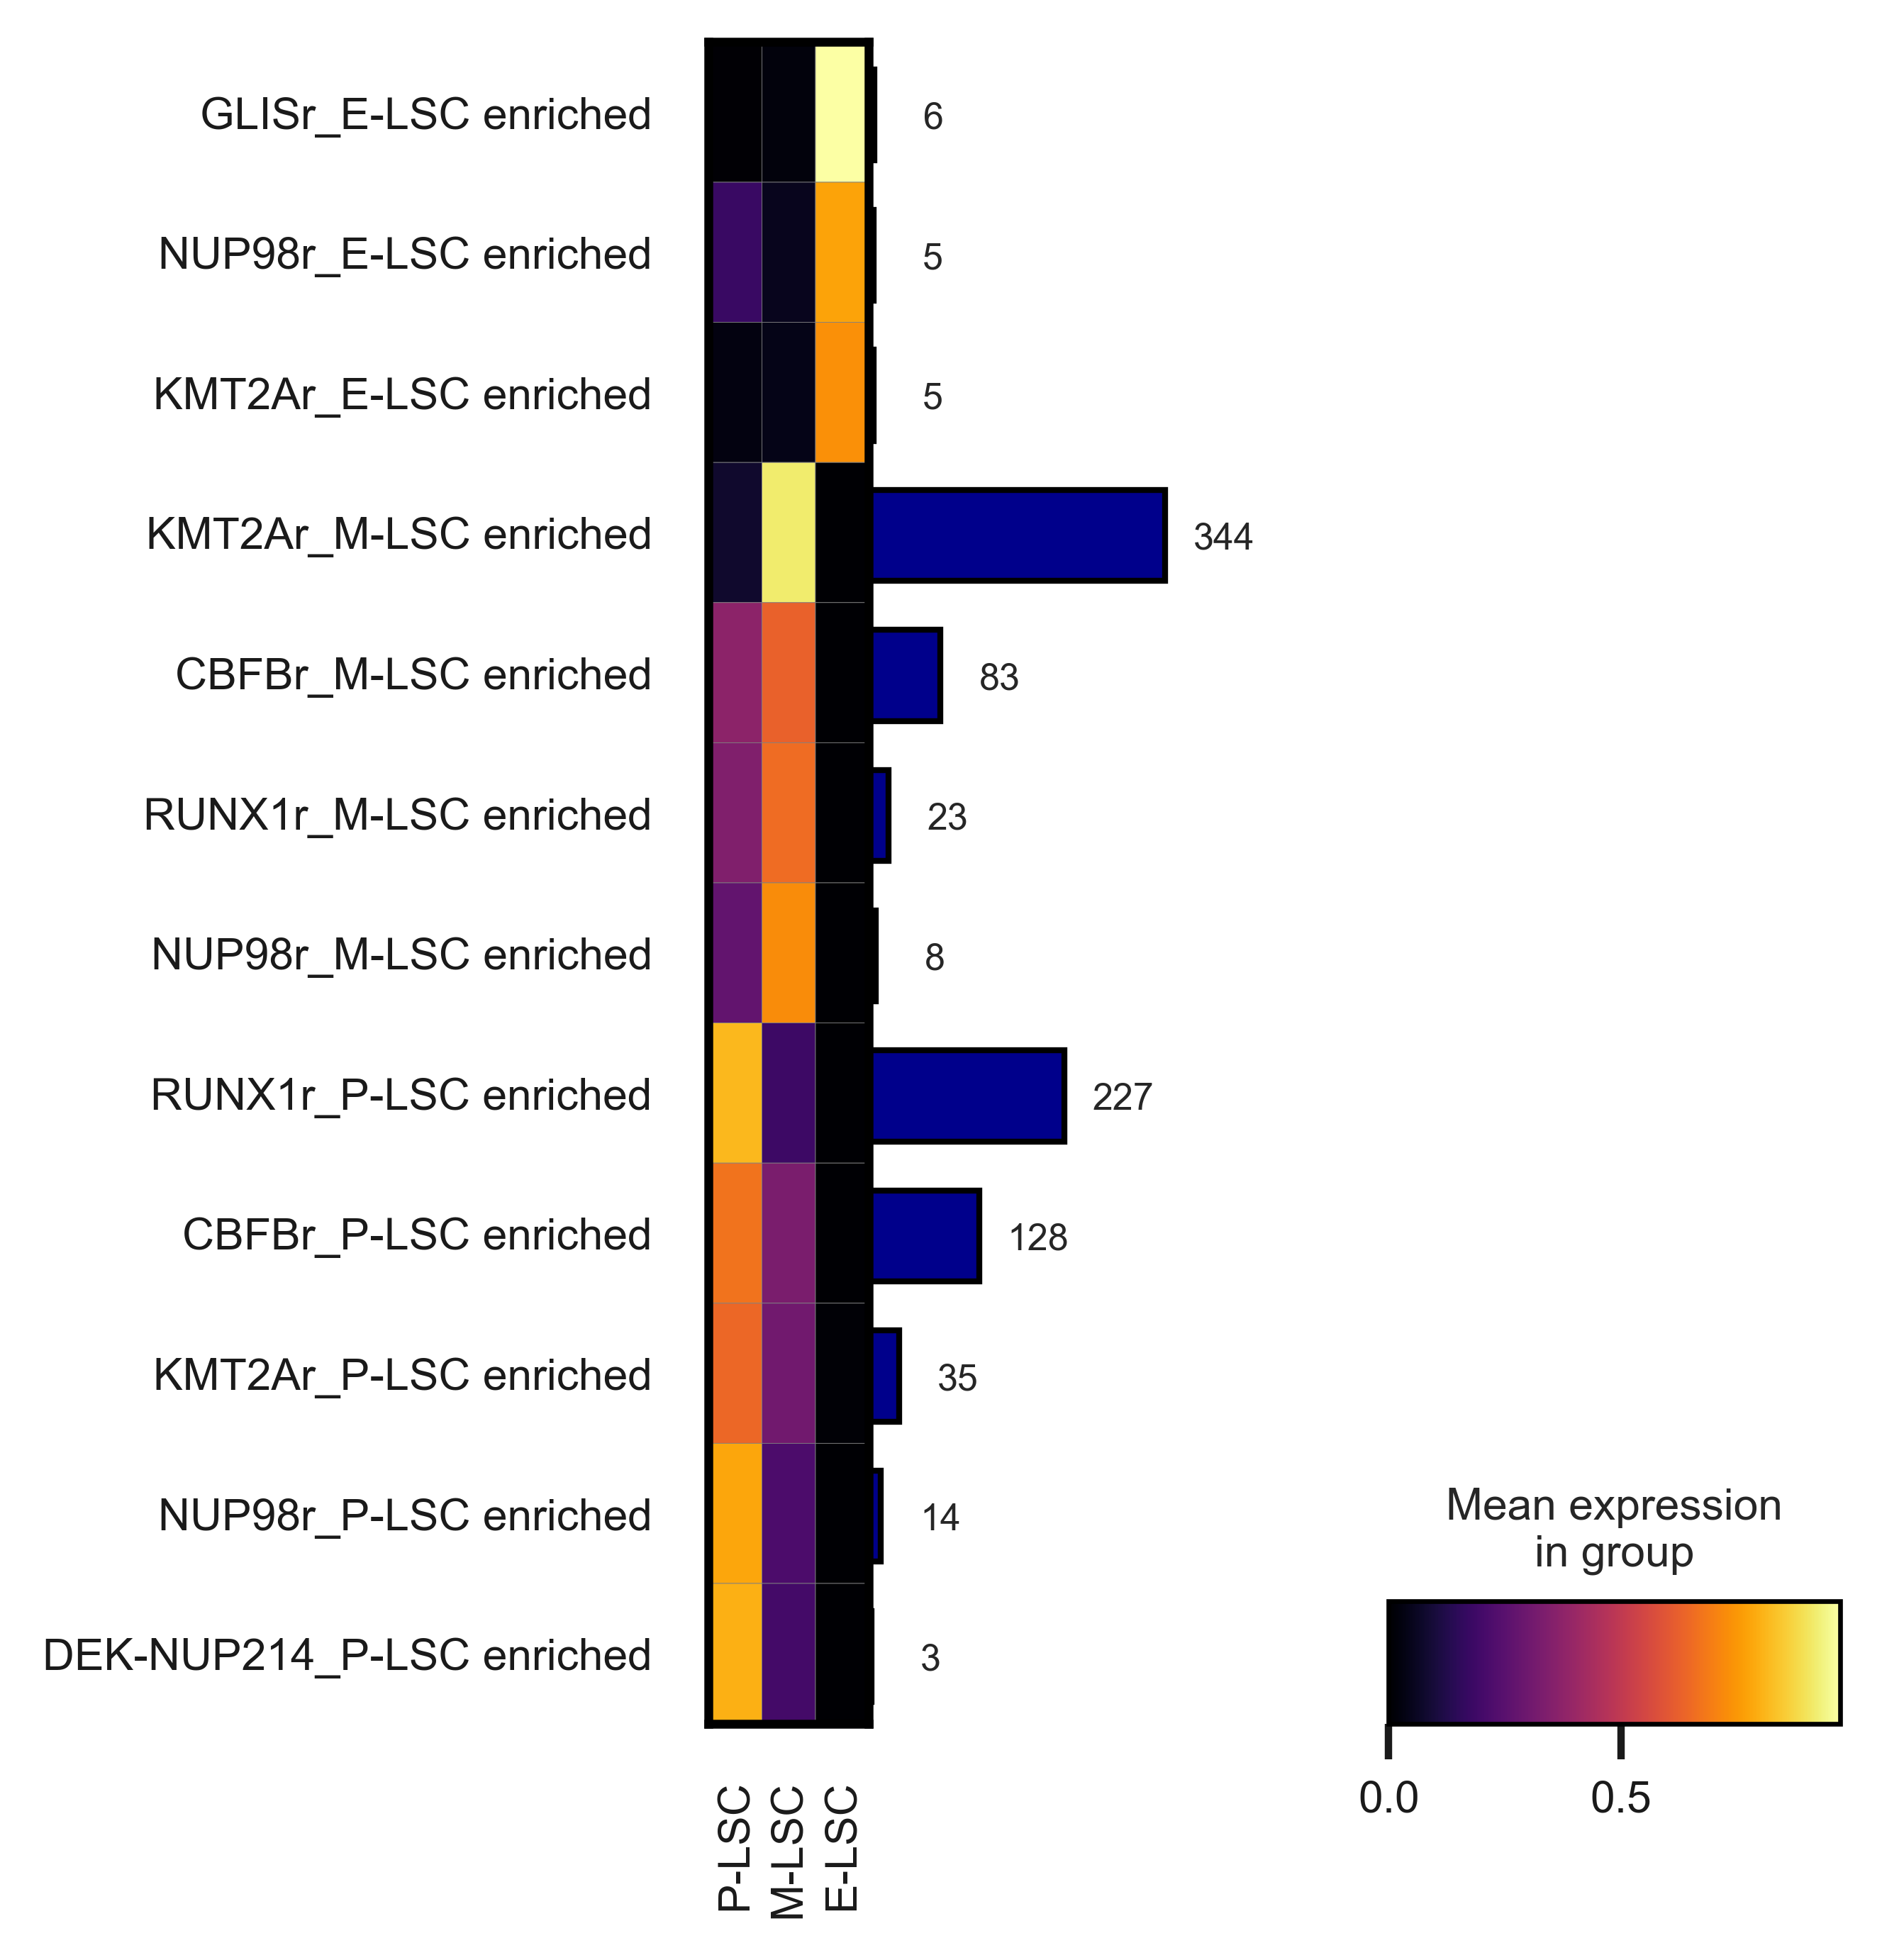

In [60]:
sc.settings.set_figure_params(
    dpi=300,
    facecolor="white",
    frameon=False, fontsize = 9
    
)

mp = sc.pl.matrixplot(target_new_clean[target_new_clean.obs["cyto_new_group"].isin(groups_plot)], groupby = "cyto_new_group", var_names = ["P-LSC","M-LSC","E-LSC"], cmap = "inferno", swap_axes = False,
categories_order = groups_plot_sorted, return_fig=True)
mp.add_totals(color = "darkblue").show()
mp.savefig("LSC_scores_TARGET.pdf")

Figure saved to: /Users/sina.kanannejad/Desktop/samplebsample/Paper_Figs/Figs/Targets/TARGET/Fig_5/cyto_CLEC12A_CD84.pdf


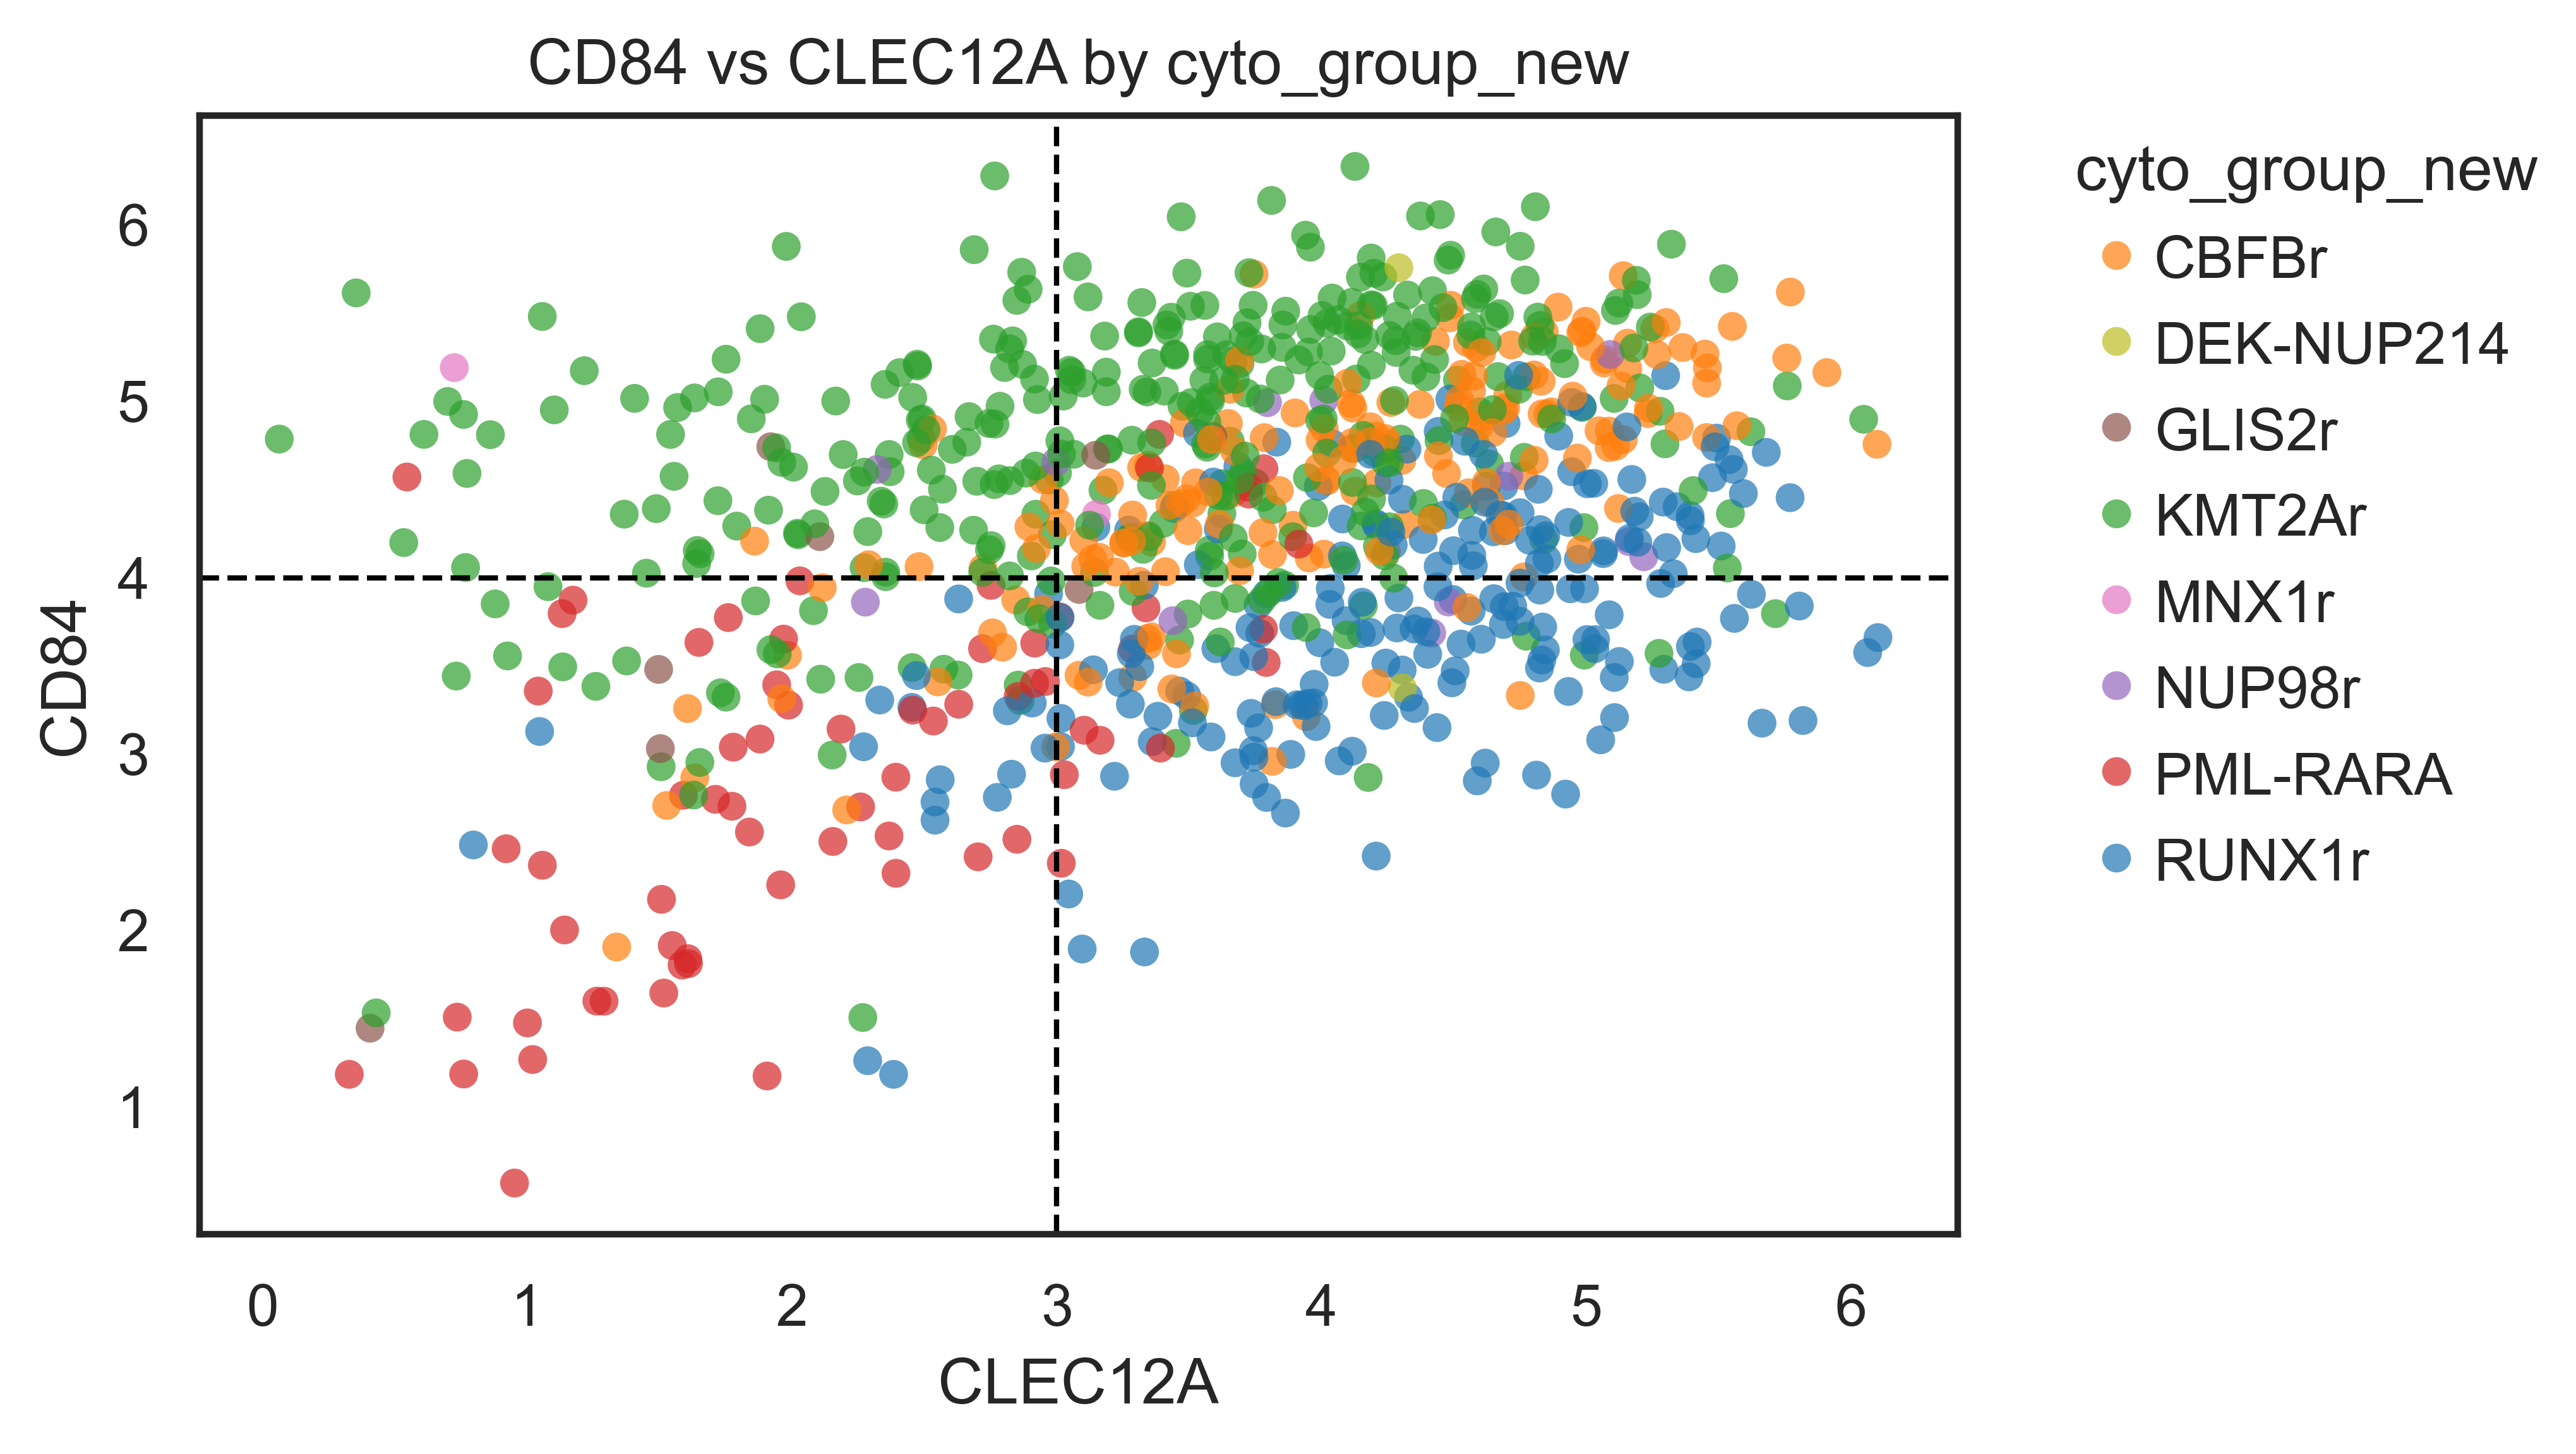

In [437]:
sns.set_theme(style="white")

plot_gene_scatter_with_lines (target_new_clean[~target_new_clean.obs["cyto_group_new"].isin(["others"])],s = 30,palette= cyto_group_new,
    gene_x = "CLEC12A", gene_y = "CD84", group_col = "cyto_group_new", x_line = 3, y_line = 4,figsize=(7, 4),
    save_path = "/cyto_CLEC12A_CD84.pdf")

In [20]:
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test, multivariate_logrank_test
from lifelines.utils import datetimes_to_durations
import warnings
warnings.filterwarnings('ignore')

def plot_survival_analysis(adata, group_col, time_col, event_col, 
                          figsize=(10, 8), palette='Set1', 
                          save_path=None, dpi=300, format='pdf',
                          title=None, xlabel='Time (days)', ylabel='Survival Probability',
                          show_pvalue=True, show_ci=True, show_at_risk=True):
    """
    Create survival plots using lifelines library.
    
    Parameters:
    -----------
    adata : AnnData
        AnnData object containing survival data in .obs
    group_col : str
        Column name in adata.obs containing group labels
    time_col : str
        Column name in adata.obs containing survival time (in days)
    event_col : str
        Column name in adata.obs containing event status (1=event occurred, 0=censored)
    figsize : tuple
        Figure size (width, height)
    palette : str or list
        Color palette for groups
    save_path : str, optional
        Path to save the plot
    dpi : int
        Resolution for saved plot
    format : str
        File format for saving
    title : str, optional
        Plot title
    xlabel : str
        X-axis label
    ylabel : str
        Y-axis label
    show_pvalue : bool
        Whether to show p-value from log-rank test
    show_ci : bool
        Whether to show confidence intervals
    show_at_risk : bool
        Whether to show number at risk table
    
    Returns:
    --------
    dict: Statistical test results and plot data
    """
    
    # Extract data from adata.obs
    survival_data = adata.obs[[group_col, time_col, event_col]].copy()
    
    # Remove rows with missing data
    survival_data = survival_data.dropna()
    
    if survival_data.empty:
        raise ValueError("No valid survival data found after removing missing values")
    
    # Check data types and convert if needed
    if not pd.api.types.is_numeric_dtype(survival_data[time_col]):
        try:
            survival_data[time_col] = pd.to_numeric(survival_data[time_col])
        except:
            raise ValueError(f"Time column '{time_col}' must be numeric")
    
    if not pd.api.types.is_numeric_dtype(survival_data[event_col]):
        try:
            survival_data[event_col] = pd.to_numeric(survival_data[event_col])
        except:
            raise ValueError(f"Event column '{event_col}' must be numeric (0=censored, 1=event)")
    
    # Get unique groups
    groups = sorted(survival_data[group_col].unique())
    
    if len(groups) < 2:
        raise ValueError("Need at least 2 groups for survival analysis")
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Initialize KaplanMeierFitter
    kmf = KaplanMeierFitter()
    
    # Store results for statistical testing
    km_curves = {}
    group_data = {}
    
    # Plot survival curves for each group
    colors = sns.color_palette(palette, len(groups))
    
    for i, group in enumerate(groups):
        group_mask = survival_data[group_col] == group
        group_survival = survival_data[group_mask]
        
        if len(group_survival) == 0:
            continue
            
        # Fit Kaplan-Meier
        kmf.fit(
            durations=group_survival[time_col],
            event_observed=group_survival[event_col],
            label=f'{group} (n={len(group_survival)})'
        )
        
        # Plot survival curve
        kmf.plot_survival_function(
            ax=ax, 
            ci_show=show_ci,
            color=colors[i]
        )
        
        # Store data for statistical testing
        km_curves[group] = kmf
        group_data[group] = group_survival
    
    # Perform log-rank or multivariate log-rank test
    p_value = None
    test_statistic = None
    test_name = None
    
    if len(groups) == 2:
        # Two groups -> standard log-rank test
        group1, group2 = groups[0], groups[1]
        
        results = logrank_test(
            group_data[group1][time_col],
            group_data[group2][time_col],
            event_observed_A=group_data[group1][event_col],
            event_observed_B=group_data[group2][event_col]
        )
        
        p_value = results.p_value
        test_statistic = results.test_statistic
        test_name = "Log-rank"
    
    else:
        # More than 2 groups -> multivariate log-rank test
        results = multivariate_logrank_test(
            event_durations=survival_data[time_col],
            groups=survival_data[group_col],
            event_observed=survival_data[event_col]
        )
        
        p_value = results.p_value
        test_statistic = results.test_statistic
        test_name = "Multivariate log-rank"
    
    # Add p-value to plot if requested
    if show_pvalue and p_value is not None:
        ax.text(
            0.05, 0.95,
            f'{test_name}: p = {p_value:.3e}',
            transform=ax.transAxes,
            fontsize=12,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
        )
    
    # Customize plot
    if title is None:
        title = f'Survival Analysis by {group_col}'
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.grid(True, alpha=0.3)
    
    # Add legend
    ax.legend(loc='lower left', fontsize=10)
    
    # Add number at risk table if requested
    if show_at_risk and len(groups) <= 4:  # Limit to 4 groups for readability
        add_at_risk_table(ax, group_data, time_col, event_col, colors)
    
    plt.tight_layout()
    
    # Save plot if path provided
    if save_path:
        plt.savefig(save_path, format=format, dpi=dpi, bbox_inches='tight')
        print(f"Survival plot saved to: {save_path}")
    
    plt.show()
    
    # Print summary statistics
    print(f"\nSurvival Analysis Summary:")
    print(f"Groups: {groups}")
    print(f"Total samples: {len(survival_data)}")
    
    for group in groups:
        if group in group_data:
            group_surv = group_data[group]
            events = group_surv[event_col].sum()
            censored = len(group_surv) - events
            median_survival = group_surv[group_surv[event_col] == 1][time_col].median()
            
            print(f"\n{group}:")
            print(f"  Sample size: {len(group_surv)}")
            print(f"  Events: {events}")
            print(f"  Censored: {censored}")
            print(f"  Median survival: {median_survival:.1f} days")
    
    if p_value is not None:
        print(f"\n{test_name} test:")
        print(f"  Test statistic: {test_statistic:.3f}")
        print(f"  p-value: {p_value:.3e}")
    
    # Return results
    results_dict = {
        'groups': groups,
        'group_data': group_data,
        'km_curves': km_curves,
        'p_value': p_value,
        'test_statistic': test_statistic,
        'test_name': test_name,
        'total_samples': len(survival_data)
    }
    
    return results_dict

def add_at_risk_table(ax, group_data, time_col, event_col, colors):
    """
    Add number at risk table below survival plot.
    """
    # Define time points for at-risk table
    max_time = max([data[time_col].max() for data in group_data.values()])
    time_points = np.linspace(0, max_time, 5)
    
    # Create at-risk table
    at_risk_data = []
    for group, data in group_data.items():
        group_risks = []
        for t in time_points:
            at_risk = len(data[data[time_col] >= t])
            group_risks.append(at_risk)
        at_risk_data.append(group_risks)
    
    # Add table below plot
    table_ax = ax.figure.add_axes([0.1, 0.05, 0.8, 0.15])
    table_ax.axis('off')
    
    # Create table
    table_data = []
    for i, (group, risks) in enumerate(zip(group_data.keys(), at_risk_data)):
        table_data.append([group] + [f'{r}' for r in risks])
    
    # Add time points as header
    time_labels = [f'{t:.0f}' for t in time_points]
    table_data.insert(0, ['Group'] + time_labels)
    
    # Create table
    table = table_ax.table(
        cellText=table_data[1:],
        colLabels=table_data[0],
        cellLoc='center',
        loc='center'
    )
    
    # Style table
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 2)
    
    # Color group names
    for i, group in enumerate(group_data.keys()):
        table[(i+1, 0)].set_facecolor(colors[i])
        table[(i+1, 0)].set_text_props(weight='bold', color='white')


In [10]:
unique_idx = (
    target_new_clean.obs.groupby('patient')
    .apply(lambda x: x.sample(1, random_state=42))
    .index.get_level_values(1)
)

# Subset the AnnData object
target_new_clean_unique = target_new_clean[unique_idx].copy()
target_new_clean_unique

/var/folders/k9/hldft9d917ld0845xc2j18040000gp/T/ipykernel_16718/1139325364.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(1, random_state=42))


AnnData object with n_obs × n_vars = 2121 × 60660
    obs: 'barcode', 'tumor.code', 'sample', 'patient', 'case.unique.id', 'tissue.code', 'nucleic.acid.code', 'definition', 'tumor.definition', 'nucleic.acid.description', 'sample_submitter_id', 'sample_type_id', 'tumor_descriptor', 'sample_id', 'sample_type', 'tumor_code', 'state', 'preservation_method', 'submitter_id', 'tumor_code_id', 'specimen_type', 'tissue_type', 'tissue_or_organ_of_origin', 'age_at_diagnosis', 'morphology', 'classification_of_tumor', 'icd_10_code', 'days_to_diagnosis', 'primary_diagnosis', 'year_of_diagnosis', 'diagnosis_is_primary_disease', 'diagnosis_id', 'site_of_resection_or_biopsy', 'race', 'gender', 'ethnicity', 'vital_status', 'age_at_index', 'days_to_birth', 'demographic_id', 'age_is_obfuscated', 'bcr_patient_barcode', 'dbgap_accession_number', 'project_id', 'name', 'releasable', 'released', 'days_to_death', 'freezing_method', 'oct_embedded', 'EFS_days', 'OS_days', 'cyto', 'cyto_prim', 'event', 'FAB_cat', 

In [59]:
def map_vital(vital_status):
    if vital_status in ["Alive"]:
        return 0
    if vital_status in ["Dead"]:
        return 1
    else:
        return 2

target_new_clean_unique.obs["vital_status_bin"] =  target_new_clean_unique.obs["vital_status"].map(map_vital)
target_new_clean_surv = target_new_clean_unique[(target_new_clean_unique.obs["vital_status_bin"].isin([0,1]))].copy()
target_new_clean_surv

In [131]:
npm1_group = target_new_clean_surv[target_new_clean_surv.obs["NPM1_mut"].isin(["Yes"])].copy()
CEBP_group = target_new_clean_surv[target_new_clean_surv.obs["CEBP_mut"].isin(["Yes"])].copy()
FLT3_group = target_new_clean_surv[target_new_clean_surv.obs["FLT-ITD"].isin(["Yes"])].copy()

In [ ]:
results = plot_survival_analysis(
    target_new_clean_surv[~target_new_clean_surv.obs["LSC_subtype"].isin(["Patient Specific"])], 
    group_col='LSC_subtype',
    time_col='EFS_days',
    event_col='vital_status_bin', figsize=(8, 4),
    palette='Set1',
    show_ci=False,
    show_at_risk=False,save_path = "/All_LSCs_survival.pdf"
)

results = plot_survival_analysis(
    npm1_group, 
    group_col='LSC_subtype',
    time_col='EFS_days',
    event_col='vital_status_bin', figsize=(8, 4),
    palette='Set1',
    show_ci=False,
    show_at_risk=False,save_path = "/NPM1_survival.pdf"
)

results = plot_survival_analysis(
    FLT3_group, 
    group_col='LSC_subtype',
    time_col='EFS_days',
    event_col='vital_status_bin', figsize=(8, 4),
    palette='Set1',
    show_ci=False,
    show_at_risk=False,save_path = "/FLT3_survival.pdf"
)

results = plot_survival_analysis(
    npm1_group, 
    group_col='LSC_subtype',
    time_col='EFS_days',
    event_col='vital_status_bin', figsize=(8, 4),
    palette='Set1',
    show_ci=False,
    show_at_risk=False,save_path = "/NPM1_survival.pdf"
)

results = plot_survival_analysis(
    target_new_clean_surv[target_new_clean_surv.obs["cyto_lsc_sub"].isin(["CBFBrP-LSC enriched","CBFBrM-LSC enriched"])], 
    group_col='cyto_lsc_sub',
    time_col='EFS_days',
    event_col='vital_status_bin', figsize=(8, 4),
    palette='Set1',
    show_ci= False,
    show_at_risk=False,save_path = "/CBFB_MYH11_survival.pdf"
)

results = plot_survival_analysis(
    target_new_clean_surv[target_new_clean_surv.obs["cyto_lsc_sub"].isin(["KMT2ArP-LSC enriched","KMT2ArM-LSC enriched"])], 
    group_col='cyto_lsc_sub',
    time_col='EFS_days',
    event_col='vital_status_bin', figsize=(8, 4),
    palette='Set1',
    show_ci=False,
    show_at_risk=False,save_path = "/KMT2A_survival.pdf"
)

results = plot_survival_analysis(
    target_new_clean_surv[target_new_clean_surv.obs["cyto_lsc_sub"].isin(["RUNX1rP-LSC enriched","RUNX1rM-LSC enriched"])], 
    group_col='cyto_lsc_sub',
    time_col='EFS_days',
    event_col='vital_status_bin', figsize=(8, 4),
    palette='Set1',
    show_ci=False,
    show_at_risk=False,save_path = "/RUNX1r_survival.pdf"
)
